In [1]:
from __future__ import division
import os
import copy
import math
import random
import scipy.stats as stats
import scipy.integrate as integrate
import numpy as np
import seaborn as sns
import pymworks
import pickle
import ExGUtils.pyexg as pyexg
from collections import Counter
from sympy import solve, Symbol
import matplotlib.pyplot as plt
%matplotlib inline

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/pymworks/protocol/__init__.py:15: UserWarning: networkx is required for pymworks.protocols.states
  warnings.warn('networkx is required for pymworks.protocols.states')


### Functions  and parameters needed to parse the pickle files

##### Parameters for running parsing

In [2]:
# pickle_files_have_phases = False
bootstrap_iterations = 100

##### Location of files

In [3]:
# filepaths of data to analyze

# stimC learning with RT bounds
fp_stimC_rtbound_base = '_data/AL_and_AM_Cohorts/newshapes_experiment/6_baselinefullcross/180825_to_180913/pickle_files_by_session/'
fp_stimC_rtbound = '_data/AL_and_AM_Cohorts/rtbound_experiment/7_stimCrtbound/181022_to_181101/pickle_files_by_session/'

##### Defining functions

**Logic:**

Function ```open_pickle_files_and_analyze()``` takes in the ```filepath``` as input, finds the pickle files, and then runs the function ```get_data```

Function ```get_data()``` takes in ```animal_name``` and ```trials_grouped_by_session``` as input, and then outputs a dictionary with the parsed data of the following form:

``` data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'iti_by_trial': iti_by_trial,
    'stim_id_by_trial': stim_id_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'iti_success_by_session': iti_success_by_session,
    'iti_failure_by_session': iti_failure_by_session,
    'stim_id_by_session': stim_id_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'pct_correct_bootstrap_error_by_session': bootstrap_error_by_session,
    'hitrate_falsealarms_by_session': hitrate_falsealarms_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_bootstrap_error_by_session': rt_success_bootstrap_error_by_session,
    'rt_failure_bootstrap_error_by_session': rt_failure_bootstrap_error_by_session,
    'rt_bootstrap_error_by_session': rt_bootstrap_error_by_session,
    'norm_session_indices': norm_session_indices
    } 
```

where:

- ***animal_name*** : animal name  
- **rt_by_trial** : list of individual trial reaction times across all sessions in pickle file
- **outcome_by_trial** : list of individual trial outcomes ('success', 'failure') across all sessions in pickle file
- **iti_by_trial** : list of individual trial intertrial intervals across all sessions in pickle file
- **stim_id_by_trial** : list of individual trial stimulus identities (e.g. 0, 1) across all sessions in pickle file

- **beh_outcome_by_session** : dict where key = session, val = of individual trial outcomes ('success', 'failure')
- **rt_by_session** : dict where key = session, val = individual trial reaction times
- **rt_success_by_session** : dict where key = session, val = individual success trial reaction times
- **rt_failure_by_session** : dict where key = session, val = individual failure trial reaction times
- **iti_by_session** : dict where key = session, val = individual trial intertrial intervals
- **iti_success_by_session**: dict where key = session, val = individual trial intertrial intervals for previous correct/success trials
- **iti_failure_by_session**: dict where key = session, val = individual trial intertrial intervals for previous incorrect/failure trials
- **stim_id_by_session**: dict where key = session, val = individual trial stimulus identities (e.g. 0, 1) 

- **pct_correct_by_session** : dict where key = session, val = accuracy for that session
- **pct_correct_bootstrap_error_by_session** : dict where key = session, val = bootstrapped accuracy error for that session
- **hitrate_falsealarms_by_session** : dict where key = session, val = dictionary with hitrate/falsealarm variables
    
- **avg_rt_success_by_session** : dict where key = session, val = avg RT for success trials in that session
- **avg_rt_failure_by_session** : dict where key = session, val = avg RT for failure trials in that session
- **rt_success_bootstrap_error_by_session** : dict where key = session, val = bootstrapped RT error for success trials in that session
- **rt_failure_bootstrap_error_by_session** : dict where key = session, val = bootstrapped RT error for failure trials in that session
- **rt_bootstrap_error_by_session** : dict where key = session, val = bootstrapped RT error for all success & failure trials in that session

- **norm_session_indices** : list of indices for sessions normalized from 0 to 1 (if animal takes 10 sessions to learn, then list contains [0.1, 0.2, 0.3,...,1.0]

the user can then use this data as she/he/they pleases. Some examples in the cells below.

In [4]:
def open_pickle_files_and_analyze(filepath):
    # get list of pickle file filenames in filepath
    dirs_list = [each for each in os.walk(filepath)]
    dirs_list = dirs_list[0][2] # capture only the pickle file filenames
    dirs_list = [i for i in dirs_list if i.startswith('.') == False] # remove hidden files

    # initiate dictionaries that will hold data
    results_by_session = {} # dictionary where keys will be animals, and values will be data
    sessions_by_animal = {} # dictionary where keys will be animals, and values will be session names

    # load the pickle files in the dirs_list one by one
    for filename in dirs_list:
        with open(filepath + filename, 'rb') as handle:
            data = pickle.load(handle)
        
        animal = data.keys()[0]# get animal name

        # notify the user of the sessions that are read
        print ' '
        print 'Read data from', animal, 'for...'
        print 'sessions:'
        for session in sorted(data[animal].keys()):
            print session

        # lump sessions from all phases into one dictionary
        trials_grouped_by_session = data[animal]
        
        # then analyze
        result_by_session = get_data(animal, trials_grouped_by_session) # analyze one animal at a time
        # store data in dictionaries
        
        results_by_session[animal] = result_by_session # add to results_by_session dictionary
        sessions_by_animal[animal] = result_by_session['avg_rt_success_by_session'].keys() # add sessions to sessions_by_animal dictionary

    print 'resultS_by_session.keys()', results_by_session.keys()
        
    return results_by_session

def get_data(animal_name, trials_grouped_by_session):
    
    # ~~~~~~~~~ Capture trial data ~~~~~~~~~
    
    data_by_trial = trial_data(trials_grouped_by_session)
    rt_by_trial = data_by_trial['rt_by_trial']
    outcome_by_trial = data_by_trial['outcome_by_trial']
    iti_by_trial = data_by_trial['iti_by_trial']
    stim_id_by_trial = data_by_trial['stim_id_by_trial']
    
    # ~~~~~~~~~ Capture session data ~~~~~~~~~
    
    data_by_session = session_data(trials_grouped_by_session)
    beh_outcome_by_session = data_by_session['beh_outcome_by_session']
    rt_by_session = data_by_session['rt_by_session']
    rt_success_by_session = data_by_session['rt_success_by_session']
    rt_failure_by_session = data_by_session['rt_failure_by_session']
    iti_by_session = data_by_session['iti_by_session']
    iti_success_by_session = data_by_session['iti_success_by_session']
    iti_failure_by_session = data_by_session['iti_failure_by_session']
    stim_id_by_session = data_by_session['stim_id_by_session']
    
    # ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

    avg_rt_success_by_session = average_data_rt(rt_success_by_session)
    avg_rt_failure_by_session = average_data_rt(rt_failure_by_session)
    avg_rt_by_session = average_data_rt(rt_by_session)

    rt_success_bootstrap_error_by_session = bootstrap_error_rt(rt_success_by_session, bootstrap_iterations)
    rt_failure_bootstrap_error_by_session = bootstrap_error_rt(rt_failure_by_session, bootstrap_iterations)
    rt_bootstrap_error_by_session = bootstrap_error_rt(rt_by_session, bootstrap_iterations)
    
    # ~~~~~~~~~~ Performance analysis ~~~~~~~~~~
    
    pct_correct_by_session = pct_correct(beh_outcome_by_session)
    pct_correct_bootstrap_error_by_session = bootstrap_error_perf(beh_outcome_by_session, bootstrap_iterations)
    hitrate_falsealarms_by_session = hitrate_falsealarms(beh_outcome_by_session, stim_id_by_session)
    
    # ~~~~~~~~~~~~ Session indices ~~~~~~~~~~~~

    norm_session_indices = [(x+1)/len(pct_correct_by_session) for x in range(len(pct_correct_by_session))]
    norm_session_indices = [(x+1)/len(avg_rt_success_by_session) for x in range(len(avg_rt_success_by_session))]

    data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'iti_by_trial': iti_by_trial,
    'stim_id_by_trial': stim_id_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'iti_success_by_session': iti_success_by_session,
    'iti_failure_by_session': iti_failure_by_session,
    'stim_id_by_session': stim_id_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'pct_correct_bootstrap_error_by_session': pct_correct_bootstrap_error_by_session,
    'hitrate_falsealarms_by_session': hitrate_falsealarms_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_bootstrap_error_by_session': rt_success_bootstrap_error_by_session,
    'rt_failure_bootstrap_error_by_session': rt_failure_bootstrap_error_by_session,
    'rt_bootstrap_error_by_session': rt_bootstrap_error_by_session,
    'norm_session_indices': norm_session_indices
    }

    return data

# ~~~~~~~~~ Capture trial data ~~~~~~~~~

# get trial data in big lists across all sessions
def trial_data(trials_grouped_by_session):
    # initialize lists for trial data across all sessions
    rt = []
    outcome = []
    iti = []
    stim_id = []

    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.iterkeys()):
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            
            # only take into account the success or failure trials
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']:
               
                # append reaction time 
                rt.append(trials[trial_index]['reaction_time'])
                # append behavior outcome
                outcome.append(trials[trial_index]['behavior_outcome'])
                # append stimulus identity
                stim_id.append(trials[trial_index]['BlobIdentityIdx'])
                
                # intertrial interval analysis
                if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                    iti.append(iti_for_first_trial)
                elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                    next_stim_time = trials[trial_index]['stim_presentation_time']
                    response_time = trials[trial_index - 1]['behavior_outcome_time'] # previous trial behavior_outcome_time
                    inter_trial_interval = (next_stim_time - response_time)*0.001 # convert to ms
                    iti.append(inter_trial_interval)
                    
                    
            # ignore the 'ignore' trials for now
            elif trials[trial_index]['behavior_outcome'] == 'ignore':
                pass 
          
    data_by_trial = {
    'rt_by_trial': rt,
    'outcome_by_trial': outcome,
    'iti_by_trial': iti,
    'stim_id_by_trial': stim_id
    }
    return data_by_trial

# ~~~~~~~~~ Capture session data ~~~~~~~~~

def session_data(trials_grouped_by_session):
    # initialize dictionaries for trial data by sessions
    beh_outcome_by_session = {}
    rt_by_session = {}
    rt_success_by_session = {}
    rt_failure_by_session = {}
    iti_by_session = {}
    iti_success_by_session = {}
    iti_failure_by_session = {}
    stim_id_by_session = {}
    
    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.iterkeys()):
        session_rt_success = []
        session_rt_failure = []
        session_rt = []
        session_behavior_outcome = []
        session_stim_id = []
        session_iti = []
        session_success_iti = []
        session_failure_iti = []
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            # behavior outcome and rt analysis
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']: # WITHOUT IGNORES
                session_rt.append(trials[trial_index]['reaction_time'])
                session_behavior_outcome.append(trials[trial_index]['behavior_outcome'])
                session_stim_id.append(trials[trial_index]['BlobIdentityIdx'])
                if trials[trial_index]['behavior_outcome'] == 'success':
                    session_rt_success.append(trials[trial_index]['reaction_time'])
                elif trials[trial_index]['behavior_outcome'] == 'failure':
                    session_rt_failure.append(trials[trial_index]['reaction_time'])
                    
            # intertrial interval analysis
            if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                session_iti.append(iti_for_first_trial)
            elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                next_stim_time = trials[trial_index]['stim_presentation_time']
                response_time = trials[trial_index - 1]['behavior_outcome_time'] # previous trial behavior_outcome_time
                inter_trial_interval = (next_stim_time - response_time)*0.001 # convert to ms
                session_iti.append(inter_trial_interval)
                
                if trials[trial_index - 1]['behavior_outcome'] == 'success': # create separate list with previous success trial itis
                    session_success_iti.append(inter_trial_interval)
                elif trials[trial_index - 1]['behavior_outcome'] == 'failure': # create separate list with previous failure trial itis
                    session_failure_iti.append(inter_trial_interval)

        beh_outcome_by_session[session] = session_behavior_outcome
        rt_by_session[session] = session_rt
        rt_success_by_session[session] = session_rt_success
        rt_failure_by_session[session] = session_rt_failure
        iti_by_session[session] = session_iti
        iti_success_by_session[session] = session_success_iti
        iti_failure_by_session[session] = session_failure_iti
        stim_id_by_session[session] = session_stim_id
        
    data_by_session = {
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'iti_success_by_session': iti_success_by_session,
    'iti_failure_by_session': iti_failure_by_session,
    'stim_id_by_session': stim_id_by_session
    }
    
    return data_by_session

# ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

def average_data_rt(data_by_session):
    avg_by_session = {}
    for session in sorted(data_by_session.iterkeys()):
        data = data_by_session[session]
        # if the session was empty, insert a NaN
        if len(data) > 0:
            avg = np.mean(data)
        elif len(data) == 0:
            avg = float('nan')
        avg_by_session[session] = avg
    return avg_by_session


def bootstrap_error_rt(data_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(data_by_session.iterkeys()):
        data = data_by_session[session]

        # print 'data'
        # print data
        # print ' '

        total_trials = len(data)
        
        # print 'len(data)'
        # print len(data)
        # print ' '
        if total_trials > 0:
            list_of_avg = []
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(data, total_trials)
                avg = np.mean(r)
                list_of_avg.append(avg)
            mean_error = np.std(list_of_avg)
            bootstrap_error_by_session[session] = mean_error
        else:
            bootstrap_error_by_session[session] = float('nan')
    return bootstrap_error_by_session

# ~~~~~~~~~~ Performance analysis ~~~~~~~~~~

def pct_correct(beh_out_by_session):
    pct_correct_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        counter = Counter(outcomes)
        if total_trials > 0:
            pct = counter['success'] / total_trials
        elif total_trials == 0:
            pct = float('nan')
        pct_correct_by_session[session] = pct
    return pct_correct_by_session


def bootstrap_error_perf(beh_out_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        list_of_pct = []
        if total_trials > 0:
            for i in xrange(bootstrap_iterations):
                r = np.random.choice(outcomes, total_trials)
                counter = Counter(r)
                pct = counter['success'] / total_trials
                list_of_pct.append(pct)
            mean_error = np.std(list_of_pct)
        elif total_trials == 0:
            mean_error = float('nan')
        bootstrap_error_by_session[session] = mean_error
    return bootstrap_error_by_session

def safe_division(x,y):
    try:
        return x/y
    except ZeroDivisionError:
        return 0
    
def hitrate_falsealarms(beh_out_by_session, stim_id_by_session):
    hitrate_falsealarms_by_session = {}
    for session in sorted(beh_out_by_session.iterkeys()):
        outcomes = beh_out_by_session[session]
        stim_ids = stim_id_by_session[session]
        possible_stim_ids = set(stim_ids)
        hitrate_falsealarms = dict.fromkeys(possible_stim_ids, 0)
        for stim_id in possible_stim_ids:
            hits = 0
            misses = 0
            falsealarms = 0
            correctrejects = 0
            total_signal_stim = 0
            total_noise_stim = 0
            outcome_by_stim = []
            for trial in range(len(stim_id_by_session[session])):
                if stim_id_by_session[session][trial] == stim_id:
                    total_signal_stim += 1
                    if beh_out_by_session[session][trial] == 'success':
                        outcome_by_stim.append('hit')
                        hits += 1
                    elif beh_out_by_session[session][trial] == 'failure':
                        outcome_by_stim.append('miss')
                        misses += 1
                elif stim_id_by_session[session][trial] != stim_id:
                    total_noise_stim += 1
                    if beh_out_by_session[session][trial] == 'failure':
                        outcome_by_stim.append('falsealarm')
                        falsealarms += 1
                    elif beh_out_by_session[session][trial] == 'success':
                        outcome_by_stim.append('correctreject')
                        correctrejects +=1
            hitrate_falsealarms[stim_id] = {
                'outcome_by_stim': outcome_by_stim,
                'hits_signal_stim': hits,
                'misses_signal_stim': misses,
                'total_signal_stim': total_signal_stim,
                'falsealarms_noise_stim': falsealarms,
                'correctrejects_noise_stim': correctrejects,
                'total_noise_stim': total_noise_stim,
                'hit_rate_signal_stim': safe_division(hits, total_signal_stim),
                'falsealarm_rate_noise_stim': safe_division(falsealarms, total_noise_stim)}
        hitrate_falsealarms_by_session[session] = hitrate_falsealarms
    return hitrate_falsealarms_by_session
                      

# ~~~~~~~~~~ Get relevant data ~~~~~~~~~~

def get_relevant_data(all_data_dict, relevant_data, all_sessions = True, sessions_to_count = 99, sessions_from_start = False):
    '''
    function that creates smaller dictionaries where animals are keys and values are lists of all data by session, or collapsed to one list
    
    input:
    all_data_dict:       dictionary outputted by open_pickle_files_and_analyze()
    relevant_data:       key for values in all_data_dict (string)
                           NOTE: this key should be for data organized by session, not by trial!
    all_sessions:        boolean var determining whether all sessions are included (True) or not (False)
                           if False, need to determine sessions_to_count, and sessions_from_start
    sessions_to_count:   number of sessions to count (i.e. 10 if want 10 sessions)
    sessions_from_start: boolean var determining whether sessions are counted from beginning of sorted list (True) or end (False)
                           e.g. if want only last 10 sessions, then: 
                           sessions_to_count = 10, sessions_from_start = False
    
    output:
    relevant_data_dict:  dictionary where key = animal, value = list of data from relevant_data key
                           where every list entry is from one session and sessions have been sorted
                           in the case of averages, such as "avg_rt_by_session", each list entry is a number
                           in the case of lists, such as "rt_by_session", each list entry is a list              
    '''
    relevant_data_dict = {}
    for animal in all_data_dict.iterkeys():
        if all_sessions == True:
            for session in sorted(all_data_dict[animal][relevant_data].keys()):
                try:
                    relevant_data_dict[animal].append(all_data_dict[animal][relevant_data][session])
                except KeyError:
                    relevant_data_dict[animal] = [all_data_dict[animal][relevant_data][session]]
        elif all_sessions == False:
            if sessions_from_start == True:
                for session in sorted(all_data_dict[animal][relevant_data].keys())[:sessions_to_count]:
                    try:
                        relevant_data_dict[animal].append(all_data_dict[animal][relevant_data][session])
                    except KeyError:
                        relevant_data_dict[animal] = [all_data_dict[animal][relevant_data][session]]
            elif sessions_from_start == False:
                for session in sorted(all_data_dict[animal][relevant_data].keys())[-sessions_to_count:]:
                    try:
                        relevant_data_dict[animal].append(all_data_dict[animal][relevant_data][session])
                    except KeyError:
                        relevant_data_dict[animal] = [all_data_dict[animal][relevant_data][session]]
    return relevant_data_dict

# ~~~~~~~~~~ Prepare inter-trial intervals ~~~~~~~~~~

def adjust_itis(iti_data, min_Drsi):
    '''
    adjust itis by subtracting minimum Drsi (Derr or Dcorr depending on type of iti) function
    '''
    iti_data_adj = {}
    for animal in iti_data.keys():
        for session in iti_data[animal]:
            try:
                iti_data_adj[animal].append([i - min_Drsi for i in session])
            except KeyError:
                iti_data_adj[animal] = [[i - min_Drsi for i in session]]
    return iti_data_adj

def avg_adjusted_itis(iti_data_adj, boundary = 2000):
    '''
    take mean of itis for all values under the boundary (don't count itis beyond the boundary') function
    '''
    iti_data_adj_mean = {}
    iti_data_adj_sem = {}
    iti_data_adj_median = {}
    for animal in iti_data_adj.keys():
        for session in iti_data_adj[animal]:
            session_below_boundary = [i for i in session if i < boundary]
            try:
                iti_data_adj_mean[animal].append(np.nanmean(session_below_boundary))
                iti_data_adj_median[animal].append(np.nanmedian(session_below_boundary))
                # regular sem
#                 iti_data_adj_sem[animal].append(stats.sem([i for i in session if i < boundary]))
            except KeyError:
                iti_data_adj_mean[animal] = [np.nanmean(session_below_boundary)]
                iti_data_adj_median[animal] = [np.nanmedian(session_below_boundary)]
#                 iti_data_adj_sem[animal] = [stats.sem([i for i in session if i < boundary])]

            # calculate bootstrap sem
            if len(session_below_boundary) > 0:
                list_of_avg = []
                for i in xrange(bootstrap_iterations):
                    r = np.random.choice(session_below_boundary, len(session_below_boundary))
                    avg = np.mean(r)
                    list_of_avg.append(avg)
                mean_error = np.std(list_of_avg)
                try:
                    iti_data_adj_sem[animal].append(mean_error)
                except KeyError:
                    iti_data_adj_sem[animal] = [mean_error]
            else:
                try:
                    iti_data_adj_sem[animal].append(float('nan'))
                except KeyError:
                    iti_data_adj_sem[animal] = [float('nan')]
    return iti_data_adj_mean, iti_data_adj_sem, iti_data_adj_median

# ~~~~~~~~~~ Convert reaction times to mean normalized decision times ~~~~~~~~~~

def convert_RTs_to_DTs(rts, iti_err = 0, t0 = 350, derr = 3136, with_itis = False):
    dts = {}
    for animal in rts.keys():
        if with_itis == True:
            for sesh in range(len(rts[animal])):
                try:
                    dts[animal].append((rts[animal][sesh] - t0)/(t0 + derr + iti_err[animal][sesh]))
                except KeyError:
                    dts[animal] = [(rts[animal][sesh] - t0)/(t0 + derr + iti_err[animal][sesh])]
        elif with_itis == False:
            dts[animal] = [(i - t0)/(t0 + derr) for i in rts[animal]]
    return dts

def calc_DT_err(rt_err, iti_err = 0, t0 = 350, derr = 3136, with_itis = False):
    dt_err = {}
    for animal in rt_err.keys():
        if with_itis == True:
            for sesh in range(len(rt_err[animal])):
                sum_sqrd_err = math.sqrt(rt_err[animal][sesh]**2 + iti_err[animal][sesh]**2)
                adj_err = sum_sqrd_err / (t0 + derr + iti_err[animal][sesh])
                try:
                    dt_err[animal].append(adj_err)
                except KeyError:
                    dt_err[animal] = [adj_err]
        elif with_itis == False:
            dt_err[animal] = [i/(t0 + derr) for i in rt_err[animal]]
        
    return dt_err

# ~~~~~~~~~~ Mesh data to create averages over learning ~~~~~~~~~~

def mesh_data(results, datakey = 'none'):
    '''
    input:
        results = dict where keys = animals, values = either dictionary with data or a list with data
        datakey = if not 'none', keys to dictionary with data
                  if none - values of results are lists
                  
    output:
        meshed_data = dict containing meshed data and meshed indices
    '''
    
    d = {}
    for animal in results.keys():
#         i = results[animal]['norm_session_indices'] # indexed session list comes pre-made from get_data_for_figure()
        if datakey == 'none':
            i = [(x+1)/len(results[animal]) for x in range(len(results[animal]))]
            y_data = results[animal]
        elif datakey != 'none':
            i = [(x+1)/len(results[animal][datakey]) for x in range(len(results[animal][datakey]))]
            y_data = results[animal][datakey]
        
        y = []
        
        if type(y_data) == dict:
            for session in sorted(y_data.iterkeys()):
                y.append(y_data[session])
            d[animal] = {'i': i, 'y': y}
        elif type(y_data) == list:
            y = y_data
            d[animal] = {'i': i, 'y': y}

    all_y = []
    all_i = []
    for a in d.iterkeys():
        # print 'key = ' + a
        if len(all_i) == 0:
            # print 'in if statement'
            all_i = d[a]['i']
            all_y = d[a]['y']
            # print all_i
            # print all_x
        else:
            # print 'in else statement'
            for j in range(len(d[a]['i'])):
                # print 'first for loop'
                for i in range(len(all_i)):
                    # print 'second for loop'
                    if all_i[i] >= d[a]['i'][j]:
                        #print 'first half'
                        #print all_x[:i]
                        all_i = all_i[:i] + [d[a]['i'][j]] + all_i[i:]
                        all_y = all_y[:i] + [d[a]['y'][j]] + all_y[i:]
                        # print all_i
                        # print all_x
                        break

    # print 'all_x:', all_x
    # print ' '
    # print 'all_i:', all_i

    meshed_data = {'all_i': all_i, 'all_y': all_y}

    return meshed_data

def avg_binned_data(meshed_data, n_bins):
    x_data = meshed_data['all_i']
    y_data = meshed_data['all_y']

    # if every animal has the exact number of sessions, add some noise to the indices to shuffle them:
    if wiggle_session_indices == True:
        x_data = [(i+(random.uniform(-1,1)/25)) for i in x_data]
    else:
        pass


    n_bins = n_bins
    
    x_n, x_bins, x_patches = plt.hist(x_data, bins = n_bins)

    # based on the bins for x_data, bin y_data
    # note that this code creates an extra bin at the end because there is one more bin value than bins
    # that is fixed with a for loop below
    y_bins = []
    for i in range(len(x_bins)):
        y_bin = []
        for j in range(len(x_data)):
            if i < (len(x_bins)-1):
                if (x_data[j] >= x_bins[i] and (x_data[j] < x_bins[i+1])):
                    y_bin.append(y_data[j])
                else:
                    pass
            elif i >= (len(x_bins)-1):
                if x_data[j] == (x_bins[i]):
                    y_bin.append(y_data[j])
                else:
                    pass
        y_bins.append(y_bin)

    # the above code creates an extra bin at the end
    # this for loop combines the last two bins
    for i in range(len(y_bins)):
        if i == (len(y_bins)-1):
            y_bins[i-1] = y_bins[i-1] + y_bins[i]
            y_bins.pop(i)
        else:
            pass

    # calculate the mean for values in every bin
    y_bins_mean = []
    y_bins_std = []
    y_bins_sem = []
    y_bins_median = []
    y_bins_25percentile = []
    y_bins_75percentile = []
    for i in y_bins:
#         if 0 in i:
#             i = [0.001 if x == 0 else x for x in i] # if there are zeroes, convert to small values to not have issues with averaging
#         else:
#             pass
        y_bins_mean.append(np.nanmean(i))
        y_bins_median.append(np.nanmedian(i))
        y_bins_25percentile.append(np.nanmedian(i) - np.nanpercentile(i, q = 25))
        y_bins_75percentile.append(np.nanpercentile(i, q = 75) - np.nanmedian(i))
        y_bins_std.append(np.nanstd(i))
        y_bins_sem.append(np.nanstd(i)/math.sqrt(len(i)))

    # calculate bin centers in order to plot the mean
    x_bincenters = [np.mean([x_bins[i],x_bins[i+1]]) for i in range(len(x_bins)-1)]

#     # Plot
#     xmin = -0.05 # indexed sessions from 0 to 1
#     xmax = 1.05
#     ymin = 0.4 # performance from 0 to 1
#     ymax = 1.0

#     fig = plt.figure()
#     plt.plot(x_data, y_data, 'r.', markersize=10, label=u'observations')
#     plt.errorbar(x_bincenters, y_bins_mean, yerr = y_bins_sem, fmt = 'bo-', label=u'binned average')
#     plt.xlabel('normalized session time')
#     plt.ylabel('mean performance $\pm$ sem')
#     plt.axis([xmin, xmax, ymin, ymax])
#     plt.legend(loc='lower right')
#     plt.savefig('AK_Cohort_perf_binned_avg.pdf')
#     plt.close()
#     # plt.show()

    avg_binned_data = {
    'x_bins': x_bins,
    'x_bincenters': x_bincenters,
    'y_bins': y_bins,
    'y_bins_mean': y_bins_mean,
    'y_bins_std': y_bins_std,
    'y_bins_sem': y_bins_sem,
    'y_bins_median': y_bins_median,
    'y_bins_25percentile': y_bins_25percentile,
    'y_bins_75percentile': y_bins_75percentile
    }

    return avg_binned_data

# ~~~~~~~~~~ calculate OPC curve ~~~~~~~~~~

def calculate_opc():
    #this function returns a dictionary with two arrays with which to plot an optimal performance curve (OPC)

    #eta = (A/sigma)^2 (signal to noise ratio (drift rate to noise))
    #theta = | threshold / A | (ratio of threshold over drift rate)
    
    #make arrays with all possible values for eta and theta
    etas = np.arange(0.0001, 4, 0.01)
    thetas = np.arange(0.0001, 2.5, 0.01)
    e, th = np.meshgrid(etas, thetas)
    #calculate possible error rates with etas and thetas
    #pre-calculate 2*etas to reduce clutter and make equation legible
    e_x_2 = np.multiply(2,e)
    p_err = (1/(1 + np.exp(e_x_2*th)))
    #p_err is a huge array of arrays, but we only need the last array
    ind = len(p_err) - 1
    p_err = p_err[ind]
    #calculate mean normalized decision time as a function of p_err
    #pre-calculate components of equation to reduce clutter and make equation legible
    term1 = 1 / np.multiply(p_err, np.log((1-p_err)/p_err))
    term2 = 1 / (1 - np.multiply(2, p_err))
    mean_norm_dt = 1 / (term1 + term2)

    return {'p_err': p_err, 'mean_norm_dt': mean_norm_dt}

# ~~~~~~~~~~ plot data in OPC space ~~~~~~~~~~

# use when inputs are dictionaries with animals as keys
def opc_during_learning(perf, perf_err, dt, dt_err, filename = '%s_opc_during_learning.pdf'):

    error_rate = {}
    error_rate_err = {}
    mean_norm_dt = {}
    mean_norm_dt_err = {}
    for animal in perf.keys():
        error_rate[animal] = [1 - i for i in perf[animal]]
        error_rate_err[animal] = perf_err[animal]
        mean_norm_dt[animal] = dt[animal]
        mean_norm_dt_err[animal] = dt_err[animal]

        opc = calculate_opc()
        x_opc = opc['p_err']
        y_opc = opc['mean_norm_dt']

        x = error_rate[animal]
        y = mean_norm_dt[animal]
        xerr = error_rate_err[animal]
        yerr = mean_norm_dt_err[animal]

        xmin = 0.0
        xmax = 0.55
        ymin = 0.0
        ymax = 0.5

        c = plt.cm.magma(np.linspace(0.,0.95,len(x)))

        plt.close()
        plt.plot(x_opc, y_opc, label = 'opc')
        plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
        plt.axis([xmin, xmax, ymin, ymax])
        plt.xlabel('error rate $\pm$ sem')
        plt.ylabel('mean normalized DT $\pm$ sem')
        plt.title('%s learning trajectory' %animal)
        plt.savefig(filename %animal)
    
       
# use with meshed data or individual animal data to only make one plot during learning
def opc_during_learning_from_list(perf, perf_err, dt, dt_err, listname = 'X Rats', filename = '_opc_during_learning.pdf'):

    error_rate = [1 - i for i in perf]
    error_rate_err = perf_err
    mean_norm_dt = dt
    mean_norm_dt_err = dt_err

    opc = calculate_opc()
    x_opc = opc['p_err']
    y_opc = opc['mean_norm_dt']

    x = error_rate
    y = mean_norm_dt
    xerr = error_rate_err
    yerr = mean_norm_dt_err

    xmin = 0.0
    xmax = 0.525
    ymin = 0.0
    ymax = 0.5

    c = plt.cm.magma(np.linspace(0.,0.95,len(x)))

    plt.close()
    plt.plot(x_opc, y_opc, label = 'opc')
    plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
    plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('error rate $\pm$ sem')
    plt.ylabel('mean normalized DT $\pm$ sem')
    plt.title(listname + ' learning trajectory')
    plt.savefig(filename)
    
# color code points by frac max rr
def opc_avg_colored_by_frac_max_rr(perf, perf_err, dt, dt_err, pct_max_rr, listname = 'X Rats', filename = '_opc_avg_across_sessions.pdf'):

    error_rate = []
    error_rate_err = []
    mean_norm_dt = []
    mean_norm_dt_err = []
    frac_max_rr = []
    for animal in perf.keys():
        error_rate.append(1 - perf[animal])
        error_rate_err.append(perf_err[animal])
        mean_norm_dt.append(dt[animal])
        mean_norm_dt_err.append(dt_err[animal])
        frac_max_rr.append(pct_max_rr[animal])

    opc = calculate_opc()
    x_opc = opc['p_err']
    y_opc = opc['mean_norm_dt']

    x = error_rate
    y = mean_norm_dt
    xerr = error_rate_err
    yerr = mean_norm_dt_err

    xmin = 0.0
    xmax = 0.5
    ymin = 0.0
    ymax = 0.55

    cmin = 0.90
    cmax = 1.0
    crange = cmax - cmin
    
    scaled_frac_max_rr = [(i - cmin)/crange for i in frac_max_rr] # rescale frac_max_rr to give color
#     cmap = plt.cm.Purples
    c = plt.cm.viridis(scaled_frac_max_rr)

    plt.close()
    plt.plot(x_opc, y_opc, label = 'opc')
    plt.errorbar(x, y, xerr = xerr, yerr = yerr, color = c, marker = ' ', linestyle = ' ', label = 'binned avg learning trajectory')
    plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel('error rate $\pm$ sem')
    plt.ylabel('mean normalized DT $\pm$ sem')
    plt.title(listname + 'average across sessions by frac max RR')
    plt.savefig(filename)

# ~~~~~~~~~~ calculate percent max reward rate ~~~~~~~~~~


# function that calculates percent max reward rate
# takes one reaction time (in seconds) and one performance

def percent_max_rr(rt, perf, t0):
    '''
    rt = reaction time, **must be in seconds**
    ER = error rate, 1 - performance
    '''
    
    Dcorr = 6.370 # correct trial ITI in s
    Derr = -3.234 # additional penalty time (can be negative) in s
#     T0 = 0.200 # non-decision time in s
    T0 = t0 # determine t0 from outside function
    
    Dtot = Dcorr + T0 + Derr # mean iti for error trials, including non-decision time
    
    # DT = Dtot*0.45 ## NEED TO FIGURE THIS OUT
    DT = rt - T0
    # ER = 0.1 # measured error rate
    ER = 1 - perf
    
    if perf <= 0.5:
        ER = 1 - 0.501
    else:
        ER = 1 - perf
    
    RRactual = (1 - ER) / (DT + Dcorr + T0 + ER*Derr) # actual reward rate attained by the measured parameters
    
    Abar = (1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # inferred signal to noise ratio (A/c)^2
    
    # now compute the optimal reward rate given this SNR
    
    z = np.logspace(-10,1,1000) # test a bunch of different thresholds
    
    ERs = [1.0/(1 + np.exp(2*i*Abar)) for i in z]
    DTs = [i*np.tanh(i*Abar) for i in z]
    RRs = [(1 - i)/(j + Dcorr + T0 + i*Derr) for i,j in zip(ERs, DTs)]
    RRoptimal = np.max(RRs)
    fraction_max_rr = RRactual/RRoptimal
    opportunity_cost = 1 - fraction_max_rr # percentage of optimal reward that they are sacrificing
    
    return fraction_max_rr

# function that calculates percent max reward rate
# takes one reaction time (in seconds) and one performance

def percent_max_rr_iti(rt, perf, t0 = 0.350, dcorr = 6.370, derr = 3.136, corr_iti = 0, err_iti = 0, with_itis = False):
    '''
    **all times must be in seconds**
    rt = reaction time
    ER = error rate, 1 - performance
    
    dcorr = experimental response-to-stimulus interval for previous correct trial
    derr = experimental response-to-stimulus interval for previous error trial
    corr_iti = extra voluntary ITI for a previous correct trial
    err_iti = extra voluntary ITI for a previous error trial
    with_itis = 
    
    '''
    
    # calculate DT and ER
    T0 = t0 # determine t0 from outside function
    DT = rt - T0
    ER = 1 - perf
    
#     if perf <= 0.5:
#         ER = 1 - 0.501
#     else:
#         ER = 1 - perf
    
    # calculate Dcorr, Derr
    if with_itis == True:
        Dcorr = dcorr + corr_iti # success time without iti or 300 ms blocking time, in seconds
        Derr = derr + err_iti # penalty time without iti or 300 ms blocking time, in seconds
        Derr_tilde = Derr - Dcorr # additional penalty time (negative when penalty time lesser than reward time) relative to Dcorr, in seconds
    elif with_itis == False:
        Dcorr = dcorr # correct trial ITI in s
        Derr = derr # additional penalty time (can be negative) in s
        Derr_tilde = Derr - Dcorr
    
    # calculate SNR (Abar) and possible ERs and DTs for that SNR
    if ER <= 0.5:
        Abar = (1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # inferred signal to noise ratio (A/c)^2
    elif ER > 0.5:
        Abar = -(1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # make SNR negative  
#         A_bar = 0 # make it zero when ER is negative 
#     Abar = (1 - 2*ER) / (2*DT)*np.log(1/ER - 1) # inferred signal to noise ratio (A/c)^2
    z = np.logspace(-10,1,1000) # test a bunch of different thresholds
    ERs = [1.0/(1 + np.exp(2*i*Abar)) for i in z]
    DTs = [i*np.tanh(i*Abar) for i in z]
    
    # calculate actual RR and possible RRs for that SNR
    if with_itis == True:
        
        # testing new RR formula...
        RRactual = (1 - ER) / (DT + (1 - ER)*Dcorr + T0 + ER*Derr)
#         RRactual = (1 - ER) / (DT + Dcorr + T0 + ER*Derr_tilde) # actual reward rate attained by the measured parameters
        
        # calculate RRs with extra voluntary ITIs
#         RRs = [(1 - i)/(j + Dcorr + T0 + i*Derr_tilde) for i,j in zip(ERs, DTs)]
        # calculate RRs without extra voluntary ITIs
        RRs = [(1 - i)/(j + (1 - i)*dcorr + T0 + i*(derr)) for i,j in zip(ERs, DTs)] # more evident RR formula
#         RRs = [(1 - i)/(j + dcorr + T0 + i*(derr - dcorr)) for i,j in zip(ERs, DTs)]
        
        
    elif with_itis == False:
        
        # testing new RR formula...
        RRactual = (1 - ER) / (DT + (1 - ER)*Dcorr + T0 + ER*Derr) # actual reward rate attained by the measured parameters
#         RRactual = (1 - ER) / (DT + Dcorr + T0 + ER*Derr_tilde) # actual reward rate attained by the measured parameters
        
        RRs = [(1 - i)/(j + (1 - i)*Dcorr + T0 + i*(Derr)) for i,j in zip(ERs, DTs)] # more evident RR formula
#         RRs = [(1 - i)/(j + Dcorr + T0 + i*Derr) for i,j in zip(ERs, DTs)]
    
    # now compute the optimal reward rate given this SNR
    RRoptimal = np.max(RRs)
    RRoptimal_ind = np.argmax(RRs) # index of max RR
    
    ERoptimal = ERs[RRoptimal_ind] # use index of max RR to get optimal ER given Abar (SNR)
    PERFoptimal = 1 - ERoptimal
    
    DToptimal = DTs[RRoptimal_ind] # use index of max RR to get optimal DT given Abar (SNR)
    DToptimal_norm = DToptimal / (T0 + Derr)
    RToptimal = DToptimal + T0
    
    fraction_max_rr = RRactual/RRoptimal
    opportunity_cost = 1 - fraction_max_rr # percentage of optimal reward that they are sacrificing
    
    return {'fraction_max_rr': fraction_max_rr,
            'opportunity_cost': opportunity_cost,
            'Abar': Abar,
            'ERs': ERs,
            'DTs': DTs,
            'RRs': RRs,
            'RRactual': RRactual,
            'RRoptimal': RRoptimal,
            'ERoptimal': ERoptimal,
            'PERFoptimal': PERFoptimal,
            'DToptimal': DToptimal,
            'RToptimal': RToptimal}

### Run the parsing

Below, the ```results``` dictionary will hold all the results for all the animals present in the pickle files in ```filepath```.

Run the cell below to populate ```results```.

In [6]:
results_by_session_7_stimCrtbound = open_pickle_files_and_analyze(fp_stimC_rtbound)

 
Read data from AL13lower for...
sessions:
AL13_181022stimClowerbound.mwk
AL13_181023stimClowerbound.mwk
AL13_181024stimClowerbound.mwk
AL13_181025stimClowerbound.mwk
AL13_181026stimClowerbound.mwk
AL13_181029stimClowerbound.mwk
AL13_181030stimClowerbound.mwk
AL13_181031stimClowerbound.mwk
AL13_181101stimClowerbound.mwk
 
Read data from AL14upper for...
sessions:
AL14_181022stimCupperbound.mwk
AL14_181023stimCupperbound.mwk
AL14_181024stimCupperbound.mwk
AL14_181025stimCupperbound.mwk
AL14_181026stimCupperbound.mwk
AL14_181029stimCupperbound.mwk
AL14_181030stimCupperbound.mwk
AL14_181031stimCupperbound.mwk
AL14_181101stimCupperbound.mwk
 
Read data from AL15lower for...
sessions:
AL15_181022stimClowerbound.mwk
AL15_181023stimClowerbound.mwk
AL15_181024stimClowerbound.mwk
AL15_181025stimClowerbound.mwk
AL15_181026stimClowerbound.mwk
AL15_181029stimClowerbound.mwk
AL15_181030stimClowerbound.mwk
AL15_181031stimClowerbound.mwk
AL15_181101stimClowerbound.mwk
 
Read data from AL16lower for.

In [7]:
results_by_session_6_baselinefullcross = open_pickle_files_and_analyze(fp_stimC_rtbound_base)

 
Read data from AL13 for...
sessions:
AL13_180825.mwk
AL13_180826.mwk
AL13_180827.mwk
AL13_180828.mwk
AL13_180829.mwk
AL13_180830.mwk
AL13_180831.mwk
AL13_180912.mwk
AL13_180913.mwk
 
Read data from AL14 for...
sessions:
AL14_180825.mwk
AL14_180826.mwk
AL14_180827.mwk
AL14_180828.mwk
AL14_180829.mwk
AL14_180830.mwk
AL14_180831.mwk
AL14_180912.mwk
AL14_180913.mwk
 
Read data from AL15 for...
sessions:
AL15_180825.mwk
AL15_180826.mwk
AL15_180827.mwk
AL15_180828.mwk
AL15_180829.mwk
AL15_180830.mwk
AL15_180831.mwk
AL15_180912.mwk
AL15_180913.mwk
 
Read data from AL16 for...
sessions:
AL16_180825.mwk
AL16_180826.mwk
AL16_180827.mwk
AL16_180828.mwk
AL16_180829.mwk
AL16_180830.mwk
AL16_180831.mwk
AL16_180912.mwk
AL16_180913.mwk
 
Read data from AL1 for...
sessions:
AL1_180825.mwk
AL1_180826.mwk
AL1_180827.mwk
AL1_180828.mwk
AL1_180829.mwk
AL1_180830.mwk
AL1_180831.mwk
AL1_180912.mwk
AL1_180913.mwk
 
Read data from AL2 for...
sessions:
AL2_180825.mwk
AL2_180826.mwk
AL2_180827.mwk
AL2_180828.m

### Learning Speed

In [8]:
relevant_data = 'pct_correct_by_session'

stimC_perf = {}
# fullcross_perf = {}

for animal in results_by_session_7_stimCrtbound.iterkeys():
    for session in sorted(results_by_session_7_stimCrtbound[animal][relevant_data]):
        try:
            stimC_perf[animal].append(results_by_session_7_stimCrtbound[animal][relevant_data][session])
        except KeyError:
            stimC_perf[animal] = [results_by_session_7_stimCrtbound[animal][relevant_data][session]]
            
# for animal in results_by_session_6_baselinefullcross.iterkeys():
#     for session in sorted(results_by_session_6_baselinefullcross[animal][relevant_data]):
#         try:
#             fullcross_perf[animal].append(results_by_session_6_baselinefullcross[animal][relevant_data][session])
#         except KeyError:
#             fullcross_perf[animal] = [results_by_session_6_baselinefullcross[animal][relevant_data][session]]

In [16]:
relevant_data = 'avg_rt_success_by_session'

stimC_RTs = {}
# fullcross_perf = {}

for animal in results_by_session_7_stimCrtbound.iterkeys():
    for session in sorted(results_by_session_7_stimCrtbound[animal][relevant_data]):
        try:
            stimC_RTs[animal].append(results_by_session_7_stimCrtbound[animal][relevant_data][session])
        except KeyError:
            stimC_RTs[animal] = [results_by_session_7_stimCrtbound[animal][relevant_data][session]]
            
# for animal in results_by_session_6_baselinefullcross.iterkeys():
#     for session in sorted(results_by_session_6_baselinefullcross[animal][relevant_data]):
#         try:
#             fullcross_perf[animal].append(results_by_session_6_baselinefullcross[animal][relevant_data][session])
#         except KeyError:
#             fullcross_perf[animal] = [results_by_session_6_baselinefullcross[animal][relevant_data][session]]

In [12]:
# relevant_data = 'rt_by_trial'

# stimC_RTs_all = {}
# # fullcross_perf = {}

# for animal in results_by_session_7_stimCrtbound.iterkeys():
#     try:
#         stimC_RTs[animal].append(results_by_session_7_stimCrtbound[animal][relevant_data])
#     except KeyError:
#         stimC_RTs[animal] = [results_by_session_7_stimCrtbound[animal][relevant_data]]

In [8]:
results_by_session_7_stimCrtbound.keys()

['AL16lower',
 'AL6upper',
 'AM4lower',
 'AL5upper',
 'AL3lower',
 'AL13lower',
 'AM2upper',
 'AL2upper',
 'AL7upper',
 'AL14upper',
 'AM3lower',
 'AM1lower',
 'AL8lower',
 'AL4upper',
 'AL15lower',
 'AL1']

In [8]:
outcome_cumsum = {}
numcorr_cumsum = {}
rt_cumsum = {}
rt_trials = {}
rt2500_cumsum = {}
rt0_cumsum = {}
rtminiti_cumsum = {}
fracmaxrr_cumsum = {}
rractual_cumsum = {}
snr_cumsum = {}
rr_func = {}
window = 250

animals_to_include = ['AL16lower',
                     'AL6upper',
                     'AM4lower',
                     'AL5upper',
                     'AL3lower',
                     'AL13lower',
                     'AM2upper',
                     'AL2upper',
                     #'AL7upper', # not enough trials with upper bound
                     'AL14upper',
                     'AM3lower',
                     #'AM1lower', # did not learn during task
                     'AL8lower',
                     #'AL4upper', # not enough trials with upper bound
                     'AL15lower'] #,
                     #'AL1']      # did not learn stim pair 2

for animal in animals_to_include:
    print animal
    # trial outcomes
    o = results_by_session_7_stimCrtbound[animal]['outcome_by_trial']
    o = np.array([1 if i == 'success' else 0 for i in o]) # convert strings to 0s and 1s
    o = o.cumsum() # perform cumulative sum
    o[window:] = o[window:] - o[:-window] # do a difference of cumulative sums to impose a window
    o = [i/window for i in o] # average across window size
    o = o[window:] # start only after the first full window
    
    # total reward (number correct)
    c = results_by_session_7_stimCrtbound[animal]['outcome_by_trial']
    c = np.array([1 if i == 'success' else 0 for i in c]) # convert strings to 0s and 1s
    c = c.cumsum() # perform cumulative sum
    c = c[window:] # start only after the first full window
    
    # reaction times
    r = np.array(results_by_session_7_stimCrtbound[animal]['rt_by_trial'])
    r_unmod = copy.deepcopy(r)
    r_min_iti = copy.deepcopy(r) # for rt + min itis
    r_2500 = copy.deepcopy(r) # for when correct trials are counted as 2500 ms (stim exposure time)
    r_0 = copy.deepcopy(r) # for when correct trials are counted as 0 ms (stim exposure time of error trials only)
    r_trials = copy.deepcopy(r)
    
    r_unmod = r_unmod.cumsum() # perform cumulative sum    
    r_unmod = r_unmod[int(window/2) : - int(window/2)] # shift half a window at beginning and truncate half a window at end to align at center
    
    for i in range(len(r_min_iti)):
        if results_by_session_7_stimCrtbound[animal]['outcome_by_trial'][i] == 'success':
            r_min_iti[i] = r_min_iti[i] + 6370
        elif results_by_session_7_stimCrtbound[animal]['outcome_by_trial'][i] == 'failure':
            r_min_iti[i] = r_min_iti[i] + 3136
    r_min_iti = r_min_iti.cumsum() # perform cumulative sum 
    r_min_iti = r_min_iti[int(window/2) : int(-window/2)] # shift half a window at beginning and truncate half a window at end to align at center

    for i in range(len(r_2500)):
        if results_by_session_7_stimCrtbound[animal]['outcome_by_trial'][i] == 'success':
            r_2500[i] = 2500
        else:
            r_2500[i] = r_2500[i]
    r_2500 = r_2500.cumsum()
    r_2500 = r_2500[int(window/2) : int(-window/2)]
    
    for i in range(len(r_0)):
        if results_by_session_7_stimCrtbound[animal]['outcome_by_trial'][i] == 'success':
            r_0[i] = 0
        else:
            r_0[i] = r_0[i]
    r_0 = r_0.cumsum()
    r_0 = r_0[int(window/2) : int(-window/2)]
    
    r_trials = r_trials.cumsum() # get a moving average of trials (not cumulative sum as in with 'r' below)
    r_trials[window:] = (r_trials[window:] - r_trials[:-window]) / window
    r_trials = r_trials[window:]
    
    frac_max_rr = [] # fraction max rr
    rr_actual = []
    snr = []
    for i in range(len(r_trials)):
        rr_func_output = percent_max_rr_iti(rt = r_trials[i]*0.001, perf = o[i], t0 = 0.16)
        frac_max_rr.append(rr_func_output['fraction_max_rr'])
        rr_actual.append(rr_func_output['RRactual'])
        snr.append(rr_func_output['Abar'])
    
    outcome_cumsum[animal] = o
    numcorr_cumsum[animal] = c
    rt_cumsum[animal] = r_unmod
    rt_trials[animal] = r_trials
    rt2500_cumsum[animal] = r_2500
    rt0_cumsum[animal] = r_0
    rtminiti_cumsum[animal] = r_min_iti
    fracmaxrr_cumsum[animal] = frac_max_rr
    rractual_cumsum[animal] = rr_actual
    snr_cumsum[animal] = snr
    rr_func[animal] = rr_func_output

AL16lower
AL6upper
AM4lower
AL5upper
AL3lower
AL13lower
AM2upper
AL2upper
AL14upper
AM3lower
AL8lower
AL15lower


In [9]:
min_or_max_len = 'max' # 'max' # stop averaging after min length of trials, or add NaNs and go to max length of trials across animals

# del outcome_cumsum['AL4upper']; del numcorr_cumsum['AL4upper']; 
# del rt_cumsum['AL4upper']; del rtminiti_cumsum['AL4upper']; 
# del fracmaxrr_cumsum['AL4upper']; del rractual_cumsum['AL4upper']

# del outcome_cumsum['AL7upper']; del numcorr_cumsum['AL7upper']; 
# del rt_cumsum['AL7upper']; del rtminiti_cumsum['AL7upper']; 
# del fracmaxrr_cumsum['AL7upper']; del rractual_cumsum['AL7upper']

# del outcome_cumsum['AM1lower']; del numcorr_cumsum['AM1lower']; 
# del rt_cumsum['AM1lower']; del rtminiti_cumsum['AM1lower']; 
# del fracmaxrr_cumsum['AM1lower']; del rractual_cumsum['AM1lower']

outcome_cumsum_upper = []; outcome_cumsum_lower = []
numcorr_cumsum_upper = []; numcorr_cumsum_lower = []
rt_cumsum_upper = []; rt_cumsum_lower = []
rt2500_cumsum_upper = []; rt2500_cumsum_lower = []
rt0_cumsum_upper = []; rt0_cumsum_lower = []
rtminiti_cumsum_upper = []; rtminiti_cumsum_lower = []
fracmaxrr_cumsum_upper = []; fracmaxrr_cumsum_lower = []
rractual_cumsum_upper = []; rractual_cumsum_lower = []
snr_cumsum_upper = []; snr_cumsum_lower = []


for animal in rt_cumsum.keys():
    if 'upper' in animal:
        outcome_cumsum_upper.append(outcome_cumsum[animal])
        numcorr_cumsum_upper.append(numcorr_cumsum[animal])
        rt_cumsum_upper.append(rt_cumsum[animal])
        rt2500_cumsum_upper.append(rt2500_cumsum[animal])
        rt0_cumsum_upper.append(rt0_cumsum[animal])
        rtminiti_cumsum_upper.append(rtminiti_cumsum[animal])
        fracmaxrr_cumsum_upper.append(fracmaxrr_cumsum[animal])
        rractual_cumsum_upper.append(rractual_cumsum[animal])
        snr_cumsum_upper.append(snr_cumsum[animal])
    elif 'lower' in animal:
        outcome_cumsum_lower.append(outcome_cumsum[animal])
        numcorr_cumsum_lower.append(numcorr_cumsum[animal])
        rt_cumsum_lower.append(rt_cumsum[animal])
        rt2500_cumsum_lower.append(rt2500_cumsum[animal])
        rt0_cumsum_lower.append(rt0_cumsum[animal])
        rtminiti_cumsum_lower.append(rtminiti_cumsum[animal])
        fracmaxrr_cumsum_lower.append(fracmaxrr_cumsum[animal])
        rractual_cumsum_lower.append(rractual_cumsum[animal])
        snr_cumsum_lower.append(snr_cumsum[animal])
    else:
        pass
    
if min_or_max_len == 'max':
    # pad with NaNs up to max length
    rt_cumsum_upper_max_length = max([len(i) for i in rt_cumsum_upper])
    for i in range(len(rt_cumsum_upper)):
        diff = rt_cumsum_upper_max_length - len(rt_cumsum_upper[i])
        outcome_cumsum_upper[i] = np.append(np.array(outcome_cumsum_upper[i]), np.zeros(diff) + np.nan)
        numcorr_cumsum_upper[i] = np.append(np.array(numcorr_cumsum_upper[i]), np.zeros(diff) + np.nan)
        rt_cumsum_upper[i] = np.append(np.array(rt_cumsum_upper[i]), np.zeros(diff) + np.nan)
        rt2500_cumsum_upper[i] = np.append(np.array(rt2500_cumsum_upper[i]), np.zeros(diff) + np.nan)
        rt0_cumsum_upper[i] = np.append(np.array(rt0_cumsum_upper[i]), np.zeros(diff) + np.nan)
        rtminiti_cumsum_upper[i] = np.append(np.array(rtminiti_cumsum_upper[i]), np.zeros(diff) + np.nan)
        fracmaxrr_cumsum_upper[i] = np.append(np.array(fracmaxrr_cumsum_upper[i]), np.zeros(diff) + np.nan)
        rractual_cumsum_upper[i] = np.append(np.array(rractual_cumsum_upper[i]), np.zeros(diff) + np.nan)
        snr_cumsum_upper[i] = np.append(np.array(snr_cumsum_upper[i]), np.zeros(diff) + np.nan)

    rt_cumsum_lower_max_length = max([len(i) for i in rt_cumsum_lower])
    for i in range(len(rt_cumsum_lower)):
        diff = rt_cumsum_lower_max_length - len(rt_cumsum_lower[i])
        outcome_cumsum_lower[i] = np.append(np.array(outcome_cumsum_lower[i]), np.zeros(diff) + np.nan)
        numcorr_cumsum_lower[i] = np.append(np.array(numcorr_cumsum_lower[i]), np.zeros(diff) + np.nan)
        rt_cumsum_lower[i] = np.append(np.array(rt_cumsum_lower[i]), np.zeros(diff) + np.nan)
        rt2500_cumsum_lower[i] = np.append(np.array(rt2500_cumsum_lower[i]), np.zeros(diff) + np.nan)
        rt0_cumsum_lower[i] = np.append(np.array(rt0_cumsum_lower[i]), np.zeros(diff) + np.nan)
        rtminiti_cumsum_lower[i] = np.append(np.array(rtminiti_cumsum_lower[i]), np.zeros(diff) + np.nan)
        fracmaxrr_cumsum_lower[i] = np.append(np.array(fracmaxrr_cumsum_lower[i]), np.zeros(diff) + np.nan) 
        rractual_cumsum_lower[i] = np.append(np.array(rractual_cumsum_lower[i]), np.zeros(diff) + np.nan)
        snr_cumsum_lower[i] = np.append(np.array(snr_cumsum_lower[i]), np.zeros(diff) + np.nan)

elif min_or_max_len == 'min':
    # truncate to min length
    rt_cumsum_upper_min_length = min([len(i) for i in rt_cumsum_upper])
    for i in range(len(rt_cumsum_upper)):
        outcome_cumsum_upper[i] = outcome_cumsum_upper[i][:rt_cumsum_upper_min_length]
        numcorr_cumsum_upper[i] = numcorr_cumsum_upper[i][:rt_cumsum_upper_min_length]
        rt_cumsum_upper[i] = rt_cumsum_upper[i][:rt_cumsum_upper_min_length]
        rt2500_cumsum_upper[i] = rt2500_cumsum_upper[i][:rt_cumsum_upper_min_length]
        rt0_cumsum_upper[i] = rt0_cumsum_upper[i][:rt_cumsum_upper_min_length]
        rtminiti_cumsum_upper[i] = rtminiti_cumsum_upper[i][:rt_cumsum_upper_min_length] 
        fracmaxrr_cumsum_upper[i] = fracmaxrr_cumsum_upper[i][:rt_cumsum_upper_min_length]
        rractual_cumsum_upper[i] = rractual_cumsum_upper[i][:rt_cumsum_upper_min_length]
        snr_cumsum_upper[i] = snr_cumsum_upper[i][:rt_cumsum_upper_min_length]
    
    rt_cumsum_lower_min_length = min([len(i) for i in rt_cumsum_lower])
    for i in range(len(rt_cumsum_lower)):
        outcome_cumsum_lower[i] = outcome_cumsum_lower[i][:rt_cumsum_lower_min_length]
        numcorr_cumsum_lower[i] = numcorr_cumsum_lower[i][:rt_cumsum_lower_min_length]
        rt_cumsum_lower[i] = rt_cumsum_lower[i][:rt_cumsum_lower_min_length]
        rt2500_cumsum_lower[i] = rt2500_cumsum_lower[i][:rt_cumsum_lower_min_length]
        rt0_cumsum_lower[i] = rt0_cumsum_lower[i][:rt_cumsum_lower_min_length]
        rtminiti_cumsum_lower[i] = rtminiti_cumsum_lower[i][:rt_cumsum_lower_min_length]
        fracmaxrr_cumsum_lower[i] = fracmaxrr_cumsum_lower[i][:rt_cumsum_lower_min_length]
        rractual_cumsum_lower[i] = rractual_cumsum_lower[i][:rt_cumsum_lower_min_length]
        snr_cumsum_lower[i] = snr_cumsum_lower[i][:rt_cumsum_lower_min_length]
else:
    pass

outcome_cumsum_upper_mean = np.nanmean(outcome_cumsum_upper, axis = 0)
outcome_cumsum_upper_sem = stats.sem(outcome_cumsum_upper, axis = 0, nan_policy = 'omit')
# outcome_cumsum_upper_sem = np.nanstd(outcome_cumsum_upper, axis = 0)/math.sqrt(len(outcome_cumsum_upper)-1)
numcorr_cumsum_upper_mean = np.nanmean(numcorr_cumsum_upper, axis = 0)
numcorr_cumsum_upper_sem = stats.sem(numcorr_cumsum_upper, axis = 0, nan_policy = 'omit')
# numcorr_cumsum_upper_sem = np.nanstd(numcorr_cumsum_upper, axis = 0)/math.sqrt(len(numcorr_cumsum_upper)-1)
rt_cumsum_upper_mean = np.nanmean(rt_cumsum_upper, axis = 0)
rt2500_cumsum_upper_mean = np.nanmean(rt2500_cumsum_upper, axis = 0)
rt0_cumsum_upper_mean = np.nanmean(rt0_cumsum_upper, axis = 0)
rtminiti_cumsum_upper_mean = np.nanmean(rtminiti_cumsum_upper, axis = 0)
fracmaxrr_cumsum_upper_mean = np.nanmean(fracmaxrr_cumsum_upper, axis = 0)
fracmaxrr_cumsum_upper_sem = stats.sem(fracmaxrr_cumsum_upper, axis = 0, nan_policy = 'omit')
# fracmaxrr_cumsum_upper_sem = np.nanstd(fracmaxrr_cumsum_upper, axis = 0)/math.sqrt(len(fracmaxrr_cumsum_upper)-1)
rractual_cumsum_upper_mean = np.nanmean(rractual_cumsum_upper, axis = 0)
rractual_cumsum_upper_sem = stats.sem(rractual_cumsum_upper, axis = 0, nan_policy = 'omit')
snr_cumsum_upper_mean = np.nanmean(snr_cumsum_upper, axis = 0)
snr_cumsum_upper_sem = stats.sem(snr_cumsum_upper, axis = 0, nan_policy = 'omit')


rractual_cumsum_cumsum_upper_mean = integrate.cumtrapz(y=rractual_cumsum_upper_mean, x=rtminiti_cumsum_upper_mean, initial=0)

outcome_cumsum_lower_mean = np.nanmean(outcome_cumsum_lower, axis = 0)
outcome_cumsum_lower_sem = stats.sem(outcome_cumsum_lower, axis = 0, nan_policy = 'omit')
# outcome_cumsum_lower_sem = np.nanstd(outcome_cumsum_lower, axis = 0)/math.sqrt(len(outcome_cumsum_lower)-1)
numcorr_cumsum_lower_mean = np.nanmean(numcorr_cumsum_lower, axis = 0)
numcorr_cumsum_lower_sem = stats.sem(numcorr_cumsum_lower, axis = 0, nan_policy = 'omit')
# numcorr_cumsum_lower_sem = np.nanstd(numcorr_cumsum_lower, axis = 0)/math.sqrt(len(numcorr_cumsum_lower)-1)
rt_cumsum_lower_mean = np.nanmean(rt_cumsum_lower, axis = 0)
rt2500_cumsum_lower_mean = np.nanmean(rt2500_cumsum_lower, axis = 0)
rt0_cumsum_lower_mean = np.nanmean(rt0_cumsum_lower, axis = 0)
rtminiti_cumsum_lower_mean = np.nanmean(rtminiti_cumsum_lower, axis = 0)
fracmaxrr_cumsum_lower_mean = np.nanmean(fracmaxrr_cumsum_lower, axis = 0)
fracmaxrr_cumsum_lower_sem = stats.sem(fracmaxrr_cumsum_lower, axis = 0, nan_policy = 'omit')
# fracmaxrr_cumsum_lower_sem = np.nanstd(fracmaxrr_cumsum_lower, axis = 0)/math.sqrt(len(fracmaxrr_cumsum_lower)-1)
rractual_cumsum_lower_mean = np.nanmean(rractual_cumsum_lower, axis = 0)
rractual_cumsum_lower_sem = stats.sem(rractual_cumsum_lower, axis = 0, nan_policy = 'omit')
# rractual_cumsum_lower_sem = np.nanstd(rractual_cumsum_lower, axis = 0)/math.sqrt(len(rractual_cumsum_lower)-1)
snr_cumsum_lower_mean = np.nanmean(snr_cumsum_lower, axis = 0)
snr_cumsum_lower_sem = stats.sem(snr_cumsum_lower, axis = 0, nan_policy = 'omit')

rractual_cumsum_cumsum_lower_mean = integrate.cumtrapz(y=rractual_cumsum_lower_mean, x=rtminiti_cumsum_lower_mean, initial=0)

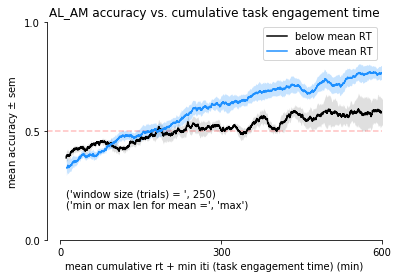

In [10]:
# ~~~~~~ plotting ~~~~~~~

# for i in range(len(rt_cumsum_upper)):
#     plt.errorbar(x = rt_cumsum_upper[i], y = outcome_cumsum_upper[i], color = 'k', alpha = 0.1)
    
# for i in range(len(rt_cumsum_lower)):
#     plt.errorbar(x = rt_cumsum_lower[i], y = outcome_cumsum_lower[i], color = 'dodgerblue', alpha = 0.1)
    
x = rtminiti_cumsum_upper_mean*0.001*(1/60)
y = outcome_cumsum_upper_mean
yerr = outcome_cumsum_upper_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'below mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

x = rtminiti_cumsum_lower_mean*0.001*(1/60)
y = outcome_cumsum_lower_mean
yerr = outcome_cumsum_lower_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'above mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([0, 0.5, 1])
plt.xticks([0, 300, 600])
plt.xlim(-25,600)
plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean accuracy $\pm$ sem')
plt.xlabel('mean cumulative rt + min iti (task engagement time) (min)')
plt.title('AL_AM accuracy vs. cumulative task engagement time')
s = 'window size (trials) = ', window
plt.text(10, 0.20, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(10, 0.15, s)
plt.legend()
sns.despine(trim = True)
# plt.savefig('_graphs_stimC_causal/AL_AM_stimC_acc_v_task_engagement_time_by_initial_diff_RT.pdf')

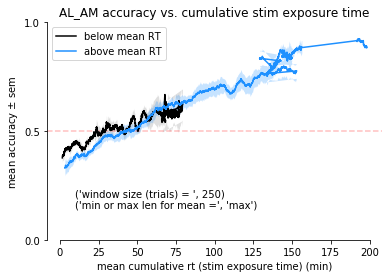

In [11]:
# ~~~~~~ plotting ~~~~~~~

# for i in range(len(rt_cumsum_upper)):
#     plt.errorbar(x = rt_cumsum_upper[i], y = outcome_cumsum_upper[i], color = 'k', alpha = 0.1)
    
# for i in range(len(rt_cumsum_lower)):
#     plt.errorbar(x = rt_cumsum_lower[i], y = outcome_cumsum_lower[i], color = 'dodgerblue', alpha = 0.1)
    
x = rt_cumsum_upper_mean*0.001*(1/60)
y = outcome_cumsum_upper_mean
yerr = outcome_cumsum_upper_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'below mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

x = rt_cumsum_lower_mean*0.001*(1/60)
y = outcome_cumsum_lower_mean
yerr = outcome_cumsum_lower_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'above mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([0, 0.5, 1])
# plt.xticks([0, 75, 150])
# plt.xlim(0,150)
plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean accuracy $\pm$ sem')
plt.xlabel('mean cumulative rt (stim exposure time) (min)')
plt.title('AL_AM accuracy vs. cumulative stim exposure time')
s = 'window size (trials) = ', window
plt.text(10, 0.20, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(10, 0.15, s)
plt.legend()
sns.despine(trim = True)
# plt.savefig('_graphs_stimC_causal/AL_AM_stimC_acc_v_stim_exposure_time_by_initial_diff_RT.pdf')

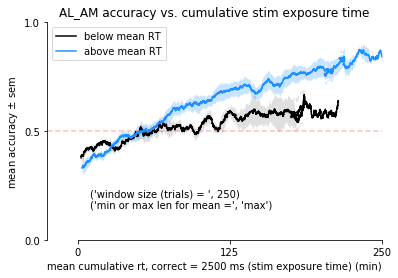

In [12]:
# ~~~~~~ plotting ~~~~~~~

# for i in range(len(rt_cumsum_upper)):
#     plt.errorbar(x = rt_cumsum_upper[i], y = outcome_cumsum_upper[i], color = 'k', alpha = 0.1)
    
# for i in range(len(rt_cumsum_lower)):
#     plt.errorbar(x = rt_cumsum_lower[i], y = outcome_cumsum_lower[i], color = 'dodgerblue', alpha = 0.1)
    
x = rt2500_cumsum_upper_mean*0.001*(1/60)
y = outcome_cumsum_upper_mean
yerr = outcome_cumsum_upper_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'below mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

x = rt2500_cumsum_lower_mean*0.001*(1/60)
y = outcome_cumsum_lower_mean
yerr = outcome_cumsum_lower_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'above mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([0, 0.5, 1])
plt.xticks([0, 125, 250])
plt.xlim(-25,250)
plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean accuracy $\pm$ sem')
plt.xlabel('mean cumulative rt, correct = 2500 ms (stim exposure time) (min)')
plt.title('AL_AM accuracy vs. cumulative stim exposure time')
s = 'window size (trials) = ', window
plt.text(10, 0.20, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(10, 0.15, s)
plt.legend(loc = 'upper left')
sns.despine(trim = True)
# plt.savefig('_graphs_stimC_causal/AL_AM_stimC_acc_v_stim_exposure_time_correct_2500ms_by_initial_diff_RT.pdf')

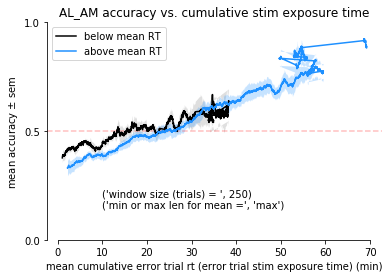

In [13]:
# ~~~~~~ plotting ~~~~~~~

# for i in range(len(rt_cumsum_upper)):
#     plt.errorbar(x = rt_cumsum_upper[i], y = outcome_cumsum_upper[i], color = 'k', alpha = 0.1)
    
# for i in range(len(rt_cumsum_lower)):
#     plt.errorbar(x = rt_cumsum_lower[i], y = outcome_cumsum_lower[i], color = 'dodgerblue', alpha = 0.1)
    
x = rt0_cumsum_upper_mean*0.001*(1/60)
y = outcome_cumsum_upper_mean
yerr = outcome_cumsum_upper_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'below mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

x = rt0_cumsum_lower_mean*0.001*(1/60)
y = outcome_cumsum_lower_mean
yerr = outcome_cumsum_lower_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'above mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([0, 0.5, 1])
# plt.xticks([0, 75, 150])
# plt.xlim(0,150)
plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean accuracy $\pm$ sem')
plt.xlabel('mean cumulative error trial rt (error trial stim exposure time) (min)')
plt.title('AL_AM accuracy vs. cumulative stim exposure time')
s = 'window size (trials) = ', window
plt.text(10, 0.20, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(10, 0.15, s)
plt.legend(loc = 'upper left')
sns.despine(trim = True)
# plt.savefig('_graphs_stimC_causal/AL_AM_stimC_acc_v_error_trial_stim_exposure_time_by_initial_diff_RT.pdf')

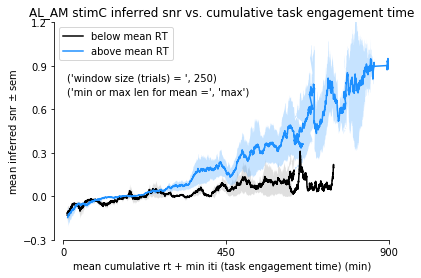

In [14]:
# ~~~~~~ plotting ~~~~~~~

# for i in range(len(rt_cumsum_upper)):
#     plt.errorbar(x = rtminiti_cumsum_upper[i]*0.001*(1/60), y = snr_cumsum_upper[i], color = 'k', alpha = 0.1)
    
# for i in range(len(rt_cumsum_lower)):
#     plt.errorbar(x = rtminiti_cumsum_lower[i]*0.001*(1/60), y = snr_cumsum_lower[i], color = 'dodgerblue', alpha = 0.1)
    
x = rtminiti_cumsum_upper_mean*0.001*(1/60)
y = snr_cumsum_upper_mean
yerr = snr_cumsum_upper_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'below mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

x = rtminiti_cumsum_lower_mean*0.001*(1/60)
y = snr_cumsum_lower_mean
yerr = snr_cumsum_lower_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'above mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([-0.3, 0, 0.3, 0.6, 0.9, 1.2])
plt.ylim(-0.3, 1.2)
plt.xticks([0, 450, 900])
plt.xlim(-25,900)
plt.ylabel('mean inferred snr $\pm$ sem')
plt.xlabel('mean cumulative rt + min iti (task engagement time) (min)')
plt.title('AL_AM stimC inferred snr vs. cumulative task engagement time')
s = 'window size (trials) = ', window
plt.text(10, 0.8, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(10, 0.7, s)
plt.legend(loc = 'upper left')
sns.despine(trim = True)
# plt.savefig('_graphs_stimC_causal/AL_AM_stimC_inferred_SNR_v_task_engagement_time_by_initial_diff_RT.pdf')

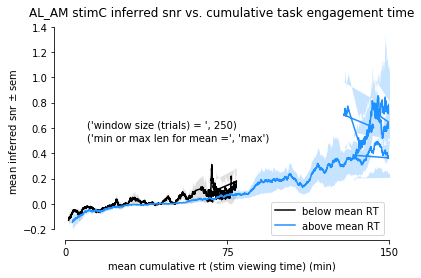

In [15]:
# ~~~~~~ plotting ~~~~~~~

# for i in range(len(rt_cumsum_upper)):
#     plt.errorbar(x = rt_cumsum_upper[i], y = outcome_cumsum_upper[i], color = 'k', alpha = 0.1)
    
# for i in range(len(rt_cumsum_lower)):
#     plt.errorbar(x = rt_cumsum_lower[i], y = outcome_cumsum_lower[i], color = 'dodgerblue', alpha = 0.1)
    
x = rt_cumsum_upper_mean*0.001*(1/60)
y = snr_cumsum_upper_mean
yerr = snr_cumsum_upper_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'below mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

x = rt_cumsum_lower_mean*0.001*(1/60)
y = snr_cumsum_lower_mean
yerr = snr_cumsum_lower_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'above mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

# plt.yticks([-0.2, 0, 0.4, 0.8])
plt.xticks([0, 75, 150])
plt.xlim(-5,150)
plt.ylabel('mean inferred snr $\pm$ sem')
plt.xlabel('mean cumulative rt (stim viewing time) (min)')
plt.title('AL_AM stimC inferred snr vs. cumulative task engagement time')
s = 'window size (trials) = ', window
plt.text(10, 0.60, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(10, 0.50, s)
plt.legend(loc = 'lower right')
sns.despine(trim = True)
plt.savefig('_graphs_stimC_causal/AL_AM_stimC_inferred_SNR_v_stim_exposure_time_by_initial_diff_RT.pdf')

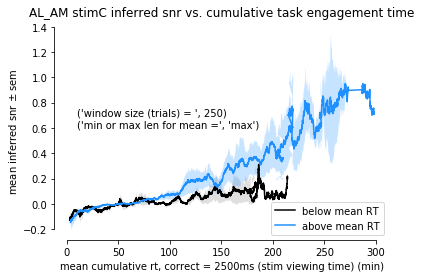

In [16]:
# ~~~~~~ plotting ~~~~~~~

# for i in range(len(rt_cumsum_upper)):
#     plt.errorbar(x = rt_cumsum_upper[i], y = outcome_cumsum_upper[i], color = 'k', alpha = 0.1)
    
# for i in range(len(rt_cumsum_lower)):
#     plt.errorbar(x = rt_cumsum_lower[i], y = outcome_cumsum_lower[i], color = 'dodgerblue', alpha = 0.1)
    
x = rt2500_cumsum_upper_mean*0.001*(1/60)
y = snr_cumsum_upper_mean
yerr = snr_cumsum_upper_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'below mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

x = rt2500_cumsum_lower_mean*0.001*(1/60)
y = snr_cumsum_lower_mean
yerr = snr_cumsum_lower_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'above mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

# plt.yticks([0, 0.5, 1])
# plt.xticks([0, 75, 150])
# plt.xlim(0,150)
plt.ylabel('mean inferred snr $\pm$ sem')
plt.xlabel('mean cumulative rt, correct = 2500ms (stim viewing time) (min)')
plt.title('AL_AM stimC inferred snr vs. cumulative task engagement time')
s = 'window size (trials) = ', window
plt.text(10, 0.70, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(10, 0.60, s)
plt.legend(loc = 'lower right')
sns.despine(trim = True)
plt.savefig('_graphs_stimC_causal/AL_AM_stimC_acc_v_stim_exposure_time_correct_2500ms_by_initial_diff_RT.pdf')

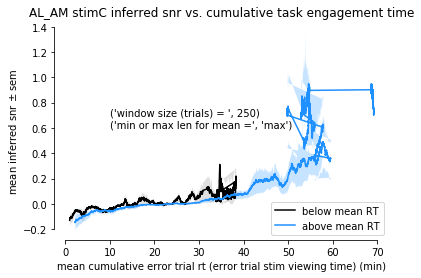

In [17]:
# ~~~~~~ plotting ~~~~~~~

# for i in range(len(rt_cumsum_upper)):
#     plt.errorbar(x = rt_cumsum_upper[i], y = outcome_cumsum_upper[i], color = 'k', alpha = 0.1)
    
# for i in range(len(rt_cumsum_lower)):
#     plt.errorbar(x = rt_cumsum_lower[i], y = outcome_cumsum_lower[i], color = 'dodgerblue', alpha = 0.1)
    
x = rt0_cumsum_upper_mean*0.001*(1/60)
y = snr_cumsum_upper_mean
yerr = snr_cumsum_upper_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'below mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)

x = rt0_cumsum_lower_mean*0.001*(1/60)
y = snr_cumsum_lower_mean
yerr = snr_cumsum_lower_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'above mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

# plt.yticks([0, 0.5, 1])
# plt.xticks([0, 75, 150])
# plt.xlim(0,150)
plt.ylabel('mean inferred snr $\pm$ sem')
plt.xlabel('mean cumulative error trial rt (error trial stim viewing time) (min)')
plt.title('AL_AM stimC inferred snr vs. cumulative task engagement time')
s = 'window size (trials) = ', window
plt.text(10, 0.70, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(10, 0.60, s)
plt.legend(loc = 'lower right')
sns.despine(trim = True)
plt.savefig('_graphs_stimC_causal/AL_AM_stimC_acc_v_error_trial_stim_exposure_time_by_initial_diff_RT.pdf')

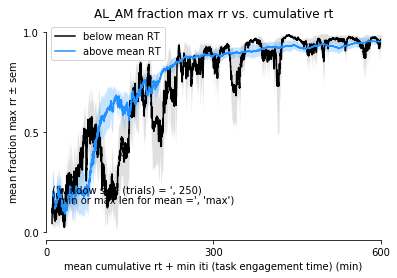

In [18]:
# ~~~~~~ plotting ~~~~~~~

# for i in range(len(rt_cumsum_upper)):
#     plt.errorbar(x = rt_cumsum_upper[i], y = rr_cumsum_upper[i], color = 'k', alpha = 0.1)
    
# for i in range(len(rt_cumsum_lower)):
#     plt.errorbar(x = rt_cumsum_lower[i], y = rr_cumsum_lower[i], color = 'dodgerblue', alpha = 0.1)
    
x = rtminiti_cumsum_upper_mean*0.001*(1/60)
y = fracmaxrr_cumsum_upper_mean
yerr = fracmaxrr_cumsum_upper_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'below mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)


x = rtminiti_cumsum_lower_mean*0.001*(1/60)
y = fracmaxrr_cumsum_lower_mean
yerr = fracmaxrr_cumsum_lower_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'above mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([0, 0.5, 1])
plt.xticks([0, 300, 600])
plt.xlim(0,600)
# plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean fraction max rr $\pm$ sem')
plt.xlabel('mean cumulative rt + min iti (task engagement time) (min)')
plt.title('AL_AM fraction max rr vs. cumulative rt')
s = 'window size (trials) = ', window
plt.text(10, 0.20, s)
s = 'min or max len for mean =', min_or_max_len
plt.text(10, 0.15, s)
plt.legend()
sns.despine(trim = True)
plt.savefig('_graphs_stimC_causal/AL_AM_stimC_mean_frac_max_RR_v_task_engagement_time_by_initial_diff_RT.pdf')

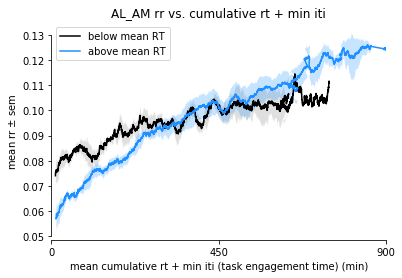

In [32]:
# ~~~~~~ plotting ~~~~~~~
    
x = rtminiti_cumsum_upper_mean*0.001*(1/60)
y = rractual_cumsum_upper_mean
yerr = rractual_cumsum_upper_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'below mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)


x = rtminiti_cumsum_lower_mean*0.001*(1/60)
y = rractual_cumsum_lower_mean
yerr = rractual_cumsum_lower_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'above mean RT')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.xticks([0, 450, 900])
plt.xlim(0,900)
plt.ylabel('mean rr $\pm$ sem')
plt.xlabel('mean cumulative rt + min iti (task engagement time) (min)')
plt.title('AL_AM rr vs. cumulative rt + min iti')
plt.legend()
sns.despine(trim = True)
plt.savefig('_graphs_stimC_causal/AL_AM_stimC_mean_RR_v_task_engagement_time_by_initial_diff_RT.pdf')

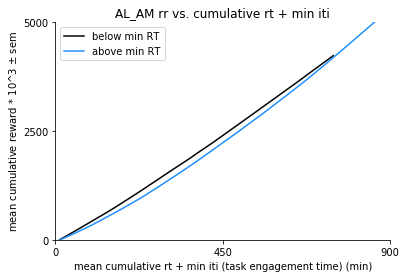

In [33]:
# ~~~~~~ plotting ~~~~~~~
    
x = rtminiti_cumsum_upper_mean*0.001*(1/60)
y = rractual_cumsum_cumsum_upper_mean*0.001
# yerr = rractual_cumsum_upper_sem
plt.errorbar(x = x, y = y, color = 'k', label = 'below min RT')
# plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)


x = rtminiti_cumsum_lower_mean*0.001*(1/60)
y = rractual_cumsum_cumsum_lower_mean*0.001
# yerr = rractual_cumsum_lower_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue', label = 'above min RT')
# plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([0,2500,5000])
plt.ylim(0,5000)
plt.xticks([0, 450, 900])
plt.xlim(0,900)
plt.ylabel('mean cumulative reward * 10^3 $\pm$ sem')
plt.xlabel('mean cumulative rt + min iti (task engagement time) (min)')
plt.title('AL_AM rr vs. cumulative rt + min iti')
plt.legend()
sns.despine(trim = True)
plt.savefig('_graphs_stimC_causal/AL_AM_stimC_mean_cumulative_reward_v_task_engagement_time_by_initial_diff_RT.pdf')

Text(0.5,1,'AL_AM total correct trials rr vs. number of trials')

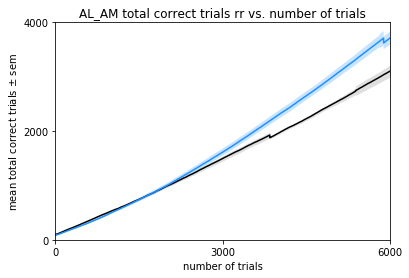

In [30]:
# ~~~~~~ plotting ~~~~~~~

# for i in range(len(rt_cumsum_upper)):
#     plt.errorbar(x = rt_cumsum_upper[i], y = rr_cumsum_upper[i], color = 'k', alpha = 0.1)
    
# for i in range(len(rt_cumsum_lower)):
#     plt.errorbar(x = rt_cumsum_lower[i], y = rr_cumsum_lower[i], color = 'dodgerblue', alpha = 0.1)
    
x = np.array(range(len(numcorr_cumsum_upper_mean)))+1
y = numcorr_cumsum_upper_mean
yerr = numcorr_cumsum_upper_sem
plt.errorbar(x = x, y = y, color = 'k')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'gray', alpha = 0.25, linewidth = 0)


x = np.array(range(len(numcorr_cumsum_lower_mean)))+1
y = numcorr_cumsum_lower_mean
yerr = numcorr_cumsum_lower_sem
plt.errorbar(x = x, y = y, color = 'dodgerblue')
plt.fill_between(x = x, y1 = y + yerr, y2 = y - yerr, color = 'dodgerblue', alpha = 0.25, linewidth = 0)

plt.yticks([0, 2000, 4000])
plt.ylim(0,4000)
plt.xticks([0, 3000, 6000])
plt.xlim(0,6000)
# plt.axhline(0.5, color = 'r', linestyle = '--', alpha = 0.25)
plt.ylabel('mean total correct trials $\pm$ sem')
plt.xlabel('number of trials')
plt.title('AL_AM total correct trials rr vs. number of trials')
# s = 'window size (trials) = ', window
# plt.text(0, 0.25, s)
# s = 'correct trials 2500 ms =', correct_2500
# plt.text(0, 0.20, s)
# s = 'min or max len for mean =', min_or_max_len
# plt.text(0, 0.15, s)

In [11]:
# new performance list that eliminates plateaus and just keeps learning phase up to that point

stimC_perf_trunc = {}
for animal in stimC_perf.keys():
    data = stimC_perf[animal]
    trunc_data = []
    thresh = 0.95
    max_p = max(data)
    for p in data:
        if p <= thresh*max_p:
            trunc_data.append(p)
        elif p > thresh*max_p:
            break
    
    stimC_perf_trunc[animal] = trunc_data

In [13]:
# new performance list that finds asymptotic performance

stimC_top_perf = {}

for animal in stimC_perf.keys():
    print 'animal:', animal
    data = [animal]
    trunc_data = []
    thresh = 0.95
    max_p = max(data)
    print 'max for animal:', max_p
    for p in data:
        if p >= thresh*max_p:
            print p
            trunc_data.append(p)
        elif p < thresh*max_p:
            pass
    
    data_dict = {
        'sessions_top_perf': trunc_data,
        'mean_top_perf': np.mean(trunc_data),
        'sem_top_perf': np.std(trunc_data)/math.sqrt(len(trunc_data))
    }
    
    stimC_top_perf[animal] = data_dict

animal: AL16lower
max for animal: AL16lower


TypeError: can't multiply sequence by non-int of type 'float'

In [14]:
# linear regression on truncated performance data

# data_dict = stimC_perf_trunc
data_dict = stimC_perf

fit_dict = {}
for key in data_dict.keys():
    # turn x-axis into sessions based on index of performance data
    x = [i+1 for i in range(len(data_dict[key]))]
    y = data_dict[key]
    
    # 1-D polynomial fit, e.g. linear regression
    par = np.polyfit(x, y, 1, full=True)
    
    slope = par[0][0]
    intercept = [par][0][1]
    # make line of best fit ('lobf')
    x_of_lobf = [min(x), max(x)]
    y_of_lobf = [slope*xx + intercept  for xx in x_of_lobf]
    
    fit_data = {
        'slope': slope,
        'intercept': intercept,
        'x_of_lobf': x_of_lobf,
        'y_of_lobf': y_of_lobf
    }
    
    fit_dict[key] = fit_data
    

stimC_learningspeed = fit_dict

LeveneResult(statistic=0.21412568073073535, pvalue=0.653458317562593)

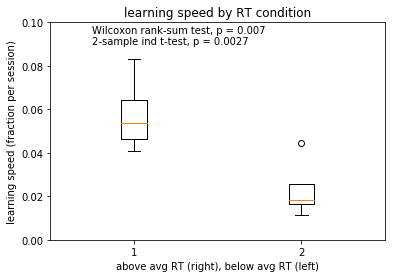

In [34]:
upper_ls = []
lower_ls = []
for animal in stimC_learningspeed:
    if 'upper' in animal and 'AL7' not in animal:
        if 'AL4' not in animal:
            upper_ls.append(stimC_learningspeed[animal]['slope'])
    elif 'lower' in animal and 'AM1' not in animal:
        lower_ls.append(stimC_learningspeed[animal]['slope'])
    else:
        pass

plt.boxplot([lower_ls, upper_ls], showcaps = True, showbox = True)
plt.ylim(0, 0.1)
plt.ylabel('learning speed (fraction per session)')
plt.xlabel('above avg RT (right), below avg RT (left)')
plt.title('learning speed by RT condition')
s = 'Wilcoxon rank-sum test, p = %.3f'  % stats.ranksums(lower_ls, upper_ls)[1]
s2 = '2-sample ind t-test, p = %.4f'  % stats.ttest_ind(lower_ls, upper_ls)[1]
plt.text(0.75, 0.095, s)
plt.text(0.75, 0.09, s2)
# plt.savefig('AL_AM_Cohort_no_AL7_AL4_AM1_learningspeed_stimC_aboveavgRT_v_belowavgRT.pdf')

# Wilcoxon rank-sum test between animals above avg RT, and animals below avg RT
# stats.ranksums(lower_ls, upper_ls)
# stats.ttest_ind(lower_ls, upper_ls)
stats.shapiro(upper_ls)
stats.levene(upper_ls, lower_ls)

In [33]:
print 'Shapiro lower_ls', stats.shapiro(lower_ls)
print 'Shapiro upper_ls', stats.shapiro(upper_ls)
print 'Levene', stats.levene(upper_ls, lower_ls)

Shapiro lower_ls (0.8963531851768494, 0.3094675838947296)
Shapiro upper_ls (0.8793836236000061, 0.30652734637260437)
Levene LeveneResult(statistic=0.21412568073073535, pvalue=0.653458317562593)


## Change in Performance / RT from Baseline

#### Distribution of reaction times, all sessions all animals, grouped by condition

{'boxes': [<matplotlib.lines.Line2D at 0x11a163cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x11a180c10>,
 'fliers': [<matplotlib.lines.Line2D at 0x11a161f10>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11a1618d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x11a163e90>,
  <matplotlib.lines.Line2D at 0x11a568210>]}

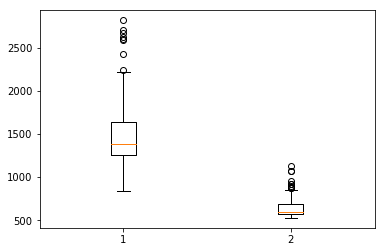

In [57]:
results_by_session_7_stimCrtbound.keys()

upper_rt = []
lower_rt = []
for animal in results_by_session_7_stimCrtbound:
    if 'upper' in animal:
        upper_rt.extend(results_by_session_7_stimCrtbound[animal]['avg_rt_success_by_session'].values())
    elif 'lower' in animal:
        lower_rt.extend(results_by_session_7_stimCrtbound[animal]['avg_rt_success_by_session'].values())
    else:
        pass
    
upper_rt = [i for i in upper_rt if str(i) != 'nan']

plt.boxplot([lower_rt, upper_rt])

#### Distribution of average reaction times per animal, grouped by condition, plotted as median and boxplot

AL16lower
AL6upper
AM4lower
AL5upper
AL3lower
AL13lower
AM2upper
AL2upper
AL14upper
AM3lower
AL8lower
AL15lower


RanksumsResult(statistic=2.6795932117057952, pvalue=0.007371167746956715)

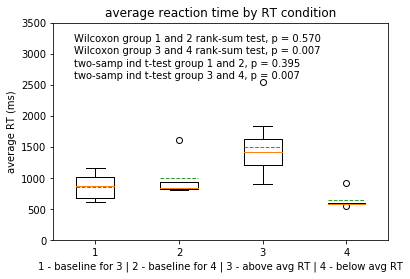

In [24]:
upper_rt_baseline = []
lower_rt_baseline = []
upper_rt = []
lower_rt = []

for animal in results_by_session_7_stimCrtbound.keys():
    up_rt = []
    up_rt_base = []
    low_rt = []
    low_rt_base = []
    if 'upper' in animal and 'AL7' not in animal:
        if 'AL4' not in animal:
            print animal
            for session in sorted(results_by_session_7_stimCrtbound[animal]['avg_rt_success_by_session'].keys()):
                up_rt.append(results_by_session_7_stimCrtbound[animal]['avg_rt_success_by_session'][session])
            for session in sorted(results_by_session_6_baselinefullcross[animal.split('u')[0]]['avg_rt_success_by_session'].keys()):
                up_rt_base.append(results_by_session_6_baselinefullcross[animal.split('u')[0]]['avg_rt_success_by_session'][session])
            upper_rt.append(up_rt)
            upper_rt_baseline.append(up_rt_base)
    elif 'lower' in animal:
        if 'AM1' not in animal:
            print animal
            for session in sorted(results_by_session_7_stimCrtbound[animal]['avg_rt_success_by_session'].keys()):
                low_rt.append(results_by_session_7_stimCrtbound[animal]['avg_rt_success_by_session'][session])
            for session in sorted(results_by_session_6_baselinefullcross[animal.split('l')[0]]['avg_rt_success_by_session'].keys()):
                low_rt_base.append(results_by_session_6_baselinefullcross[animal.split('l')[0]]['avg_rt_success_by_session'][session])
            lower_rt.append(low_rt)
            lower_rt_baseline.append(low_rt_base)   

# take mean RT from average of averages of last two sessions
upper_rt_baseline_means = [np.nanmean(i[-2:]) for i in upper_rt_baseline]
lower_rt_baseline_means = [np.nanmean(i[-2:]) for i in lower_rt_baseline]

upper_rt_means = [np.nanmean(i) for i in upper_rt]
lower_rt_means = [np.nanmean(i) for i in lower_rt]


plt.boxplot([lower_rt_baseline_means, upper_rt_baseline_means, lower_rt_means, upper_rt_means], showmeans = True, meanline = True)
plt.ylim(0, 3500)
plt.ylabel('average RT (ms)')
plt.xlabel('1 - baseline for 3 | 2 - baseline for 4 | 3 - above avg RT | 4 - below avg RT')
plt.title('average reaction time by RT condition')
s = 'Wilcoxon group 1 and 2 rank-sum test, p = %.3f'  % stats.ranksums(lower_rt_baseline_means, upper_rt_baseline_means)[1]
plt.text(0.75, 3200, s)
s = 'Wilcoxon group 3 and 4 rank-sum test, p = %.3f'  % stats.ranksums(lower_rt_means, upper_rt_means)[1]
plt.text(0.75, 3000, s)
s = 'two-samp ind t-test group 1 and 2, p = %.3f'  % stats.ttest_ind(lower_rt_baseline_means, upper_rt_baseline_means)[1]
plt.text(0.75, 2800, s)
s = 'two-samp ind t-test group 3 and 4, p = %.3f'  % stats.ttest_ind(lower_rt_means, upper_rt_means)[1]
plt.text(0.75, 2600, s)

# plt.savefig('avg_rt_stimC_aboveavgRT_v_belowavgRT.pdf')

# Wilcoxon rank-sum test between animals above avg RT, and animals below avg RT
stats.ranksums(lower_rt_means, upper_rt_means)

In [26]:
print stats.shapiro(lower_rt_baseline_means)
print stats.shapiro(upper_rt_baseline_means)
print stats.shapiro(lower_rt_means)
print stats.shapiro(upper_rt_means)

(0.9073251485824585, 0.37766289710998535)
(0.6805827021598816, 0.005933156702667475)
(0.8976230621337891, 0.31683021783828735)
(0.6583098769187927, 0.0033299182541668415)


#### Distribution of average reaction times per animal, grouped by condition, plotted as mean and individual animals

In [224]:
# function to calculate bootstrapped error used below

def btstrap_err(data, bootstrap_iterations = 1000):
    total_trials = len(data)
    if total_trials > 0:
        list_of_avg = []
        for i in xrange(bootstrap_iterations):
            r = np.random.choice(data, total_trials)
            avg = np.mean(r)
            list_of_avg.append(avg)
        mean_error = np.std(list_of_avg)
        mean_upper_CI = np.mean(list_of_avg) - np.percentile(list_of_avg, 0.975)
        mean_lower_CI = np.mean(list_of_avg) - np.percentile(list_of_avg, 0.025)
    else:
        mean_error = float('nan')
    return mean_error, [mean_lower_CI, mean_upper_CI]

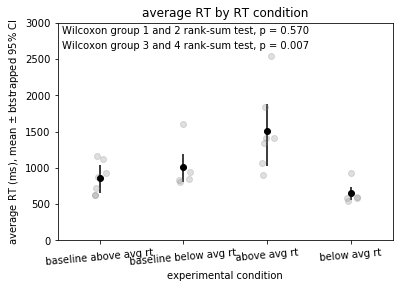

In [231]:
# code to make the plot below

x_means = [0,1,2,3]
y_means = [np.mean(lower_rt_baseline_means), np.mean(upper_rt_baseline_means), np.mean(lower_rt_means), np.mean(upper_rt_means)]

# calculate SEM through formula
lower_rt_baseline_means_sem = np.std(lower_rt_baseline_means)/math.sqrt(len(lower_rt_baseline_means))
upper_rt_baseline_means_sem = np.std(upper_rt_baseline_means)/math.sqrt(len(upper_rt_baseline_means))
lower_rt_means_sem = np.std(lower_rt_means)/math.sqrt(len(lower_rt_means))
upper_rt_means_sem = np.std(upper_rt_means)/math.sqrt(len(upper_rt_means))

# calculate confidence interval assuming t-distribution:
lower_rt_baseline_means_95CI = 2.37*lower_rt_baseline_means_sem # 2.37 is critical value for t-distribution with n-1 df (n = 8)
upper_rt_baseline_means_95CI = 2.45*upper_rt_baseline_means_sem # 2.45 is critical value for t-distribution with n-1 df (n = 7)
lower_rt_means_95CI = 2.37*lower_rt_means_sem # 2.37 is critical value for t-distribution with n-1 df (n = 8)
upper_rt_means_95CI = 2.45*upper_rt_means_sem # 2.45 is critical value for t-distribution with n-1 df (n = 7)

# calculate non-parametric SEM and 95CI through bootstrapping
lower_rt_baseline_means_btstrap_sem, lower_rt_baseline_means_btstrap_CI = btstrap_err(lower_rt_baseline_means)
upper_rt_baseline_means_btstrap_sem, upper_rt_baseline_means_btstrap_CI = btstrap_err(upper_rt_baseline_means)
lower_rt_means_btstrap_sem, lower_rt_means_btstrap_CI = btstrap_err(lower_rt_means)
upper_rt_means_btstrap_sem, upper_rt_means_btstrap_CI = btstrap_err(upper_rt_means)

# choose the desired error here

# y_means_err = [lower_rt_baseline_means_95CI, upper_rt_baseline_means_95CI, lower_rt_means_95CI, upper_rt_means_95CI]
# y_means_err = [lower_rt_baseline_means_sem, upper_rt_baseline_means_sem, lower_rt_means_sem, upper_rt_means_sem]
# y_means_err = [lower_rt_baseline_means_btstrap_sem, upper_rt_baseline_means_btstrap_sem, lower_rt_means_btstrap_sem, upper_rt_means_btstrap_sem]
y_means_err = np.transpose([lower_rt_baseline_means_btstrap_CI, upper_rt_baseline_means_btstrap_CI, lower_rt_means_btstrap_CI, upper_rt_means_btstrap_CI]) # have to transpose so the unequal (above/below) bootstrapped error bars can be used by plt.errorbar below

# plot the individual animal averages first, in gray
for i in range(len(lower_rt_means)):
    jiggle = np.random.uniform(-0.1, 0.1) # create some random noise
    x = [0+jiggle, 2+jiggle] # add that noise to the dot locations so they don't exactly overlap
    y = [lower_rt_baseline_means[i], lower_rt_means[i]]
    plt.plot(x, y, marker = 'o', color = 'gray', linestyle = ' ', alpha = 0.25)

for i in range(len(upper_rt_means)):
    jiggle = np.random.uniform(-0.1, 0.1)
    x = [1+jiggle, 3+jiggle]
    y = [upper_rt_baseline_means[i], upper_rt_means[i]]
    plt.plot(x, y, marker = 'o', color = 'gray', linestyle = ' ', alpha = 0.25)

# plot the mean of the animals' individual averages, and add the error bars
labels = ['baseline above avg rt', 'baseline below avg rt', 'above avg rt', 'below avg rt']
plt.errorbar(x_means, y_means, yerr = y_means_err, marker = 'o', linestyle = ' ', color = 'black')
plt.xlim(-0.5, 3.5)
plt.ylim(0, 3000)
# plt.axhline(y = 0, linestyle = '--', color = 'r', linewidth = 0.5)
plt.xticks(x_means, labels, rotation=5)
# plt.ylabel('average RT (ms), mean $\pm$ sem')
plt.ylabel('average RT (ms), mean $\pm$ btstrapped 95% CI')
plt.xlabel('experimental condition')
plt.title('average RT by RT condition')
s = 'Wilcoxon group 1 and 2 rank-sum test, p = %.3f'  % stats.ranksums(lower_rt_baseline_means, upper_rt_baseline_means)[1]
plt.text(-0.45, 2850, s)
s = 'Wilcoxon group 3 and 4 rank-sum test, p = %.3f'  % stats.ranksums(lower_rt_means, upper_rt_means)[1]
plt.text(-0.45, 2650, s)
plt.savefig('avg_rt_stimC_no_AL7_AL4_AM1_baseline_and_aboveavgRT_v_belowavgRT.pdf')

#### Performance curve across sessions for both conditions

condition2: AL13lower
condition1: AL14upper
condition2: AL15lower
condition2: AL16lower
condition1: AL2upper
condition2: AL3lower
condition1: AL5upper
condition1: AL6upper
condition2: AL8lower
condition1: AM2upper
condition2: AM3lower
condition2: AM4lower


Text(0.5,1,'mean perf upper (grey) v lower (blue) rt bound (AL & AM, no AL7, AL4, AM1)')

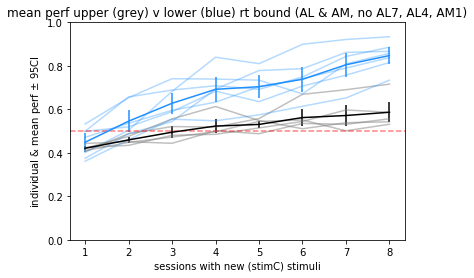

In [27]:
# Plot change in RT from baseline for this condition

stimC_perf
# fullcross_perf

sessions_to_count = 2
condition1 = 'upper'
condition2 = 'lower'

diffs = []
RTs = []

perfs1 = []
perfs2 = []

for animal in sorted(stimC_perf.keys()):
    if condition1 in animal and 'AL7' not in animal: # in case you want to eliminate animals from the analysis # AM4 has one fewer session than rest
        if 'AL4' not in animal:
            print 'condition1:', animal
    #         diff = [i - np.mean(fullcross_RTs[animal.split('_')[0]][-sessions_to_count:]) for i in transp_RTs[animal]]
    #         diffs.append(diff)
            perf = stimC_perf[animal][-8:]
    #         perf = fullcross_perf[animal.split('_')[0]][-4:]
    #         perf = fullcross_perf[animal.split('_')[0]][-4:] + [float('nan')] + transp_perf[animal]
    #         RT = fullcross_RTs[animal.split('_')[0]][-4:] + [float('nan')] + transp_RTs[animal]
    #         RTs.append(RT)
            perfs1.append(perf)


    #         y = diff
            y = perf
    #         y = RT 
            x = [i+1 for i in range(len(y))]
            plt.plot(x, y, label = animal, color = 'gray', alpha = 0.5)
    elif condition2 in animal and 'AM1' not in animal: # in case you want to eliminate animals from the analysis # AM4 has one fewer session than rest
        print 'condition2:', animal
        perf = stimC_perf[animal][-8:]
        perfs2.append(perf)
        
        y = perf
        x = [i+1 for i in range(len(y))]
        plt.plot(x, y, label = animal, color = 'dodgerblue', alpha = 0.33)
    else:
        pass


# diff_lengths = []
# for l in diffs:
#     diff_lengths.append(len(l))

# n_of_sessions = 13
# for i in range(len(diffs)):
#     diffs[i] = diffs[i][:n_of_sessions]
    

# diffs_avg = np.nanmean(diffs, axis = 0)
# std = np.nanstd(diffs, axis = 0)
# sem = std / math.sqrt(len(diffs_avg))

perfs1_avg = np.nanmean(perfs1, axis = 0)
std1 = np.nanstd(perfs1, axis = 0)
sem1 = std1 / math.sqrt(len(perfs1_avg))

perfs2_avg = np.nanmean(perfs2, axis = 0)
std2 = np.nanstd(perfs2, axis = 0)
sem2 = std2 / math.sqrt(len(perfs2_avg))

# RTs_avg = np.nanmean(RTs, axis = 0)
# std = np.nanstd(RTs, axis = 0)
# sem = std / math.sqrt(len(RTs_avg))

# y = diffs_avg
# y = perfs_avg
# y = RTs_avg
y1 = perfs1_avg
y2 = perfs2_avg
x = [i+1 for i in range(len(y))]
              
plt.errorbar(x, y1, yerr = sem1*1.96, color = 'black', label = 'RT upper bound')
plt.errorbar(x, y2, yerr = sem2*1.96, color = 'dodgerblue', label = 'RT lower bound')
# plt.errorbar(x, y, color = 'k')
# plt.ylim(-75, 275)
# plt.ylim(350, 1800)
# plt.xlim(0.5,5.5)
plt.ylim (0.0, 1.0)
plt.axhline(y = 0.5, linestyle = '--', color = 'r', alpha = 0.5)
plt.xlabel('sessions with new (stimC) stimuli')
plt.ylabel('individual & mean perf $\pm$ 95CI')
plt.title('mean perf upper (grey) v lower (blue) rt bound (AL & AM, no AL7, AL4, AM1)')
# plt.legend()
# plt.savefig('AL_AM_Cohorts_no_AL7_AL4_AM1_avg_perf_stimC_upper_v_lower_rt_bound_181022_to_181101_95CI.pdf')

#### RT across sessions for both groups

condition2: AL13lower
condition1: AL14upper
condition2: AL15lower
condition2: AL16lower
condition1: AL2upper
condition2: AL3lower
condition1: AL5upper
condition1: AL6upper
condition2: AL8lower
condition1: AM2upper
condition2: AM3lower
condition2: AM4lower


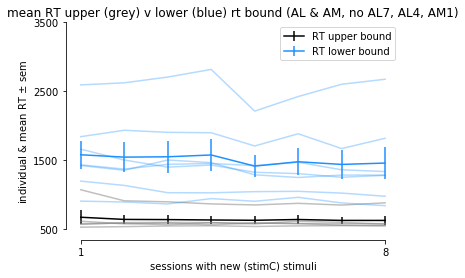

In [31]:
# Plot change in RT from baseline for this condition

stimC_RTs
# fullcross_perf

sessions_to_count = 2
condition1 = 'upper'
condition2 = 'lower'

RTs1 = []
RTs2 = []

for animal in sorted(stimC_RTs.keys()):
    if condition1 in animal and 'AL7' not in animal: # in case you want to eliminate animals from the analysis # AM4 has one fewer session than rest
        if 'AL4' not in animal:
            print 'condition1:', animal
            RT = np.array(stimC_RTs[animal][-8:])
            RTs1.append(RT)
            y = RT 
            x = np.array([i+1 for i in range(len(y))])
            plt.plot(x, y, color = 'gray', alpha = 0.5)
    elif condition2 in animal and 'AM1' not in animal: # in case you want to eliminate animals from the analysis # AM4 has one fewer session than rest
        print 'condition2:', animal
        RT = np.array(stimC_RTs[animal][-8:])
        RTs2.append(RT)
        y = RT
        x = np.array([i+1 for i in range(len(y))])
        plt.plot(x, y, color = 'dodgerblue', alpha = 0.33)
    else:
        pass

RTs1_avg = np.nanmean(RTs1, axis = 0)
sem1 = stats.sem(RTs1, axis = 0)

RTs2_avg = np.nanmean(RTs2, axis = 0)
sem2 = stats.sem(RTs2, axis = 0)

y1 = RTs1_avg
y2 = RTs2_avg
x = [i+1 for i in range(len(y))]
              
plt.errorbar(x, y1, yerr = sem1, color = 'black', label = 'RT upper bound')
plt.errorbar(x, y2, yerr = sem2, color = 'dodgerblue', label = 'RT lower bound')
plt.ylim(350, 3500)
plt.yticks([500, 1500, 2500, 3500])
plt.xticks([1, 8])
plt.xlabel('sessions with new (stimC) stimuli')
plt.ylabel('individual & mean RT $\pm$ sem')
plt.title('mean RT upper (grey) v lower (blue) rt bound (AL & AM, no AL7, AL4, AM1)')
plt.legend()
sns.despine(trim = 'true')
plt.savefig('_graphs_stimC_causal/AL_AM_stimC_stimC_upper_v_lower_rt_bound_RT_by_session_no_AL7_AL4_AM1.pdf')

## Stats on Performance

In [28]:
perfs1_transp = np.array(perfs1).T # lists are organized by animal, not by session, so organize by session
perfs2_transp = np.array(perfs2).T

for i in range(len(perfs1_transp)):
    print 'Session:', i+1
    print 'Shapiro 1:', stats.shapiro(perfs1_transp[i])
    print 'Shapiro 2:', stats.shapiro(perfs2_transp[i])
    print 'Levene:', stats.levene(perfs1_transp[i], perfs2_transp[i])
    print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

Session: 1
Shapiro 1: (0.9340105056762695, 0.6239624619483948)
Shapiro 2: (0.8958922624588013, 0.30682894587516785)
Levene: LeveneResult(statistic=6.326286732789219, pvalue=0.03063777344729281)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Session: 2
Shapiro 1: (0.9380516409873962, 0.652198076248169)
Shapiro 2: (0.8460322022438049, 0.1130107045173645)
Levene: LeveneResult(statistic=2.278030902490142, pvalue=0.1621479542189453)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Session: 3
Shapiro 1: (0.9630565643310547, 0.8290912508964539)
Shapiro 2: (0.9058099985122681, 0.367624431848526)
Levene: LeveneResult(statistic=1.2221275905940796, pvalue=0.29483042757464695)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Session: 4
Shapiro 1: (0.7607988119125366, 0.03735461086034775)
Shapiro 2: (0.9727784991264343, 0.9177138209342957)
Levene: LeveneResult(statistic=0.8569874902708091, pvalue=0.37638328157251394)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Session: 5
Shapiro 1: (0.8921334743499756, 0.36794498562812805)
Shapiro 2: (0.9778788089752197,

In [29]:
for i in range(len(perfs1_transp)):
    t, p = stats.ttest_ind(perfs1_transp[i], perfs2_transp[i], equal_var = True)
    print 'session:', i+1, 'p-value =', p

session: 1 p-value = 0.4013724731871492
session: 2 p-value = 0.04064365641414356
session: 3 p-value = 0.005725558304977886
session: 4 p-value = 0.003843492013823273
session: 5 p-value = 0.0010757743956364193
session: 6 p-value = 0.003826147894202113
session: 7 p-value = 0.0006345669961751888
session: 8 p-value = 6.365774999321085e-05
